# Part F: Generate figures and make analysis

## Introduction
This notebook contains _all code_ that has been used to create the figures and perform the analysis for the paper "Can more detailed geological maps improve streamflow prediction in ungauged basins?" paper by do Nascimento et al. (in review). To be able to run this notebook, please ensure that you have downloaded the acompanying data of the paper, and to have run all the codes before. All links can be found in the data section of the paper.

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

## Requirements

**Files**

- estreams_gauging_stations.csv https://doi.org/10.5281/zenodo.14778580 (Last access: 11 February 2025)
- estreams_geology_moselle_regional_attributes.csv https://doi.org/10.5281/zenodo.14778580 (Last access: 15 February 2025)
- estreams_attributes_filtered_quality_geology_v01.csv https://github.com/thiagovmdon/LSH-quality_geology (Last access: 11 February 2025)



## Import modules

In [ ]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import tqdm as tqdm
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from neuralhydrology.evaluation.signatures import (
    baseflow_index, hfd_mean, high_q_dur, high_q_freq, low_q_dur,
    low_q_freq, q5, q95, q_mean, runoff_ratio, slope_fdc, stream_elas, zero_q_freq
)


import matplotlib as mpl
import matplotlib.ticker as ticker

## Configurations

In [ ]:
# Path to where the EStreams dataset is stored
# Eawag
path_estreams = r'/Users/nascimth/Documents/data/EStreams'

## Personal
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

# Path to where other datasets are stored
# Eawag
path_data = r"/Users/nascimth/Documents/data"

## Import data

### Shapefiles

In [3]:
moselle=gpd.read_file(r"../data/shps/moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"../data/shps/rivers_moselle.shp")
catchment_boundaries = gpd.read_file(path_data+'//EStreams/shapefiles/estreams_catchments.shp')
catchment_boundaries.set_index("basin_id", inplace=True)

### Geological maps (clipped to the Moselle basin)


In [4]:
##################################################################################################################
# Global geology clipped to the Moselle catchment
GLiM_moselle = gpd.read_file(path_data+"/gis/paper_moselle//raster/glim_moselle_wgs.shp")

attribute_field = 'xx'
GLiM_moselle_dissolved = GLiM_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_moselle_dissolved["class"] = GLiM_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_glim = {
    "very low": ['ev', 'ig', 'pa', 'pb', 'va', 'vb', "wb"],
    "low": ['mt', 'pi', 'py', 'vi'],
    "medium": ['sc', 'sm'],
    "high": ['su', 'ss']
}

# Create a new column for reclassified permeability
def reclassify_glim_class(class_name):
    for permeability, classes in permeability_columns_glim.items():
        if class_name in classes:
            return permeability
    return None

GLiM_moselle_dissolved['permeability'] = GLiM_moselle_dissolved['class'].apply(reclassify_glim_class)

##################################################################################################################
# Continental geology clipped to the Moselle catchment
geology_median_moselle = gpd.read_file(path_data+"/gis/paper_moselle//raster/geology_median_moselle_wgs.shp")

attribute_field = 'LEVEL3'
geology_median_moselle_dissolved = geology_median_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_median_moselle_dissolved["class"] = geology_median_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Conglomerates", "Conglomerates and sands", "Gravels", 
             "Sands", "Sandstones", "Sandstones and sands"],
    "medium": ["Conglomerates and clays", "Gneisses", "Limestones", 
               "Limestones and sands", "Sandstones and clays", "Sandstones and marls",
               "Limestones and clays", "Limestones and marls", "Marlstones and sands"],
    "low": ["Claystones and clays", "Marbles",
              "Marls", "Marlstones", "Marlstones and clays", 
              "Marlstones and marls", "Phyllites", "Schists",
              "Silts"],
    "very low": ["Plutonic rocks", "Volcanic rocks", 
                    "Inland water", "Snow field / ice field",
                    "Clays",  'Quartzites', "Shales"]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_median_moselle_dissolved['permeability'] = geology_median_moselle_dissolved['class'].apply(reclassify_geology_class)

##################################################################################################################
# Regional geology clipped to the Moselle catchment
geology_high_moselle = gpd.read_file(path_data+'/gis/lithology/moselle_hr_ff.shp')

attribute_field = 'Labels01'
geology_high_moselle_dissolved = geology_high_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_high_moselle_dissolved["class"] = geology_high_moselle_dissolved.index

# Set the CRS to WGS84
geology_high_moselle_dissolved = geology_high_moselle_dissolved.to_crs(epsg=4326)


# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Alluvium", 'Coal', 'Conglomerate', 'Gravel and sand',
             'Sand', 'Sand and gravel', 'Sandstone and conglomerate', 'Sandstone'
        ],
    
    "medium": ['Limestone', 'Sandstone and marl', 'Sandstone and schist',
              'Sandstone, conglomerate and marl'],
    
    "low": ['Arkose', 'Dolomite rock', 'Limestone and marl', 'Marl', 
             'Marl and dolomite', 'Marl and limestone', 'Marl and sandstone',
             'Sandstone and siltstone', 'Sandstone, siltstone and schist', 
              'Schist and sandstone', 'Silt',  'Silt and schist', 'Siltstone, sandstone and schist'
              ,"Siltstone"
             ],
    
    "very low": ['Cristallin basement', 'Plutonic rock',  'Quarzite',
                    'Schist','Volcanic rock' 
                   ]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_high_moselle_dissolved['permeability'] = geology_high_moselle_dissolved['class'].apply(reclassify_geology_class)

### Topography

Current CRS: EPSG:4326
Image is already in WGS84 CRS.


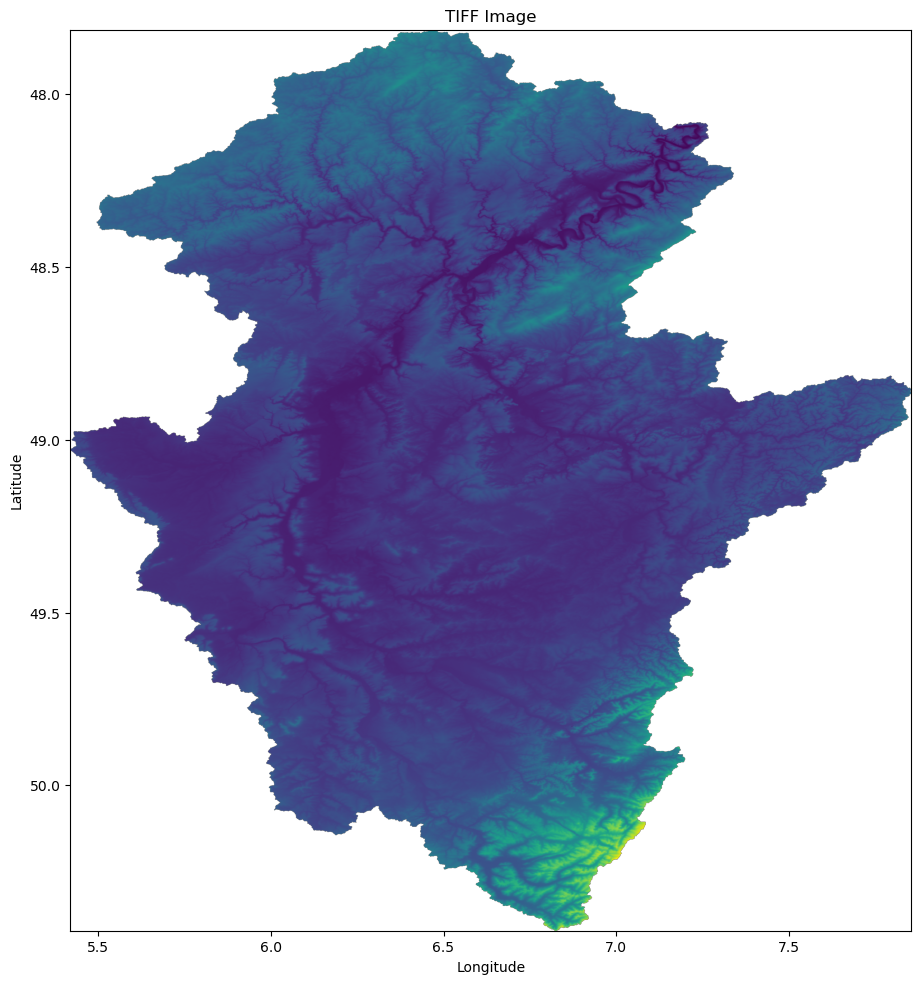

In [5]:
##################################################################################################################
# Terrain (elevation)
# Path to the TIFF file
tiff_path = path_data+"/gis/paper_moselle/raster/elevation/moselle_srtm.tif"

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    # Check the current CRS
    current_crs = src.crs
    print(f'Current CRS: {current_crs}')

    # Define the target CRS (WGS84)
    dst_crs = 'EPSG:4326'  # WGS84

    # If the current CRS is not WGS84, reproject the image
    if current_crs != dst_crs:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create an in-memory array to hold the reprojected data
        reprojected_image = rasterio.io.MemoryFile().open(**kwargs)

        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(reprojected_image, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

        # Read the reprojected image
        elevation_wgs = reprojected_image.read(1)

        print(f'Image reprojected to WGS84 and stored in-memory.')
    else:
        # Read the original image if it is already in WGS84
        elevation_wgs = src.read(1)
        transform = src.transform
        print('Image is already in WGS84 CRS.')

# Calculate the extent
left, bottom, right, top = transform * (0, 0), transform * (elevation_wgs.shape[1], 0), transform * (elevation_wgs.shape[1], elevation_wgs.shape[0]), transform * (0, elevation_wgs.shape[0])
extent = (left[0], right[0], bottom[1], top[1])

# Plot the image with the correct extent
fig, ax = plt.subplots(1, 1, figsize=(16.6, 11.7))
ax.imshow(elevation_wgs, cmap='viridis', extent=extent)
ax.set_title('TIFF Image')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Network and attributes

In [6]:
# Read the gauges network metadata (from EStreams):
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Attributes already filtered from EStreams previously in do Nascimento et al. (2025a):
estreams_attributes = pd.read_csv('../data/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')
estreams_attributes.set_index("basin_id", inplace = True)

# Geological attributes (regional scale). Same ones provided in do Nascimento et al. (2025a):
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')
geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)


# Read the dataset network
estreams_attributes_clipped_filters = pd.read_csv(R'../data/network_estreams_moselle_108_gauges.csv', encoding='utf-8')
estreams_attributes_clipped_filters.set_index("basin_id", inplace = True)

## Preprocessing
### Network organization

In [7]:
# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)


# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

### Geological data organization

In [8]:
# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

### Attributes organization

In [9]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])

100%|██████████| 1/1 [00:00<00:00, 735.33it/s]


## Merging simulations
Here we simply do the merging of the simualtions into single netcdfs to fascilitate the work.

In [10]:
# Base path to your NetCDF files
base_path = Path(r"../results/sim/space-time/notconcatenated")
base_path_output= Path(r"../results/sim/space-time")
# List of group suffixes
group_suffixes = [f"Group_{i}" for i in range(1, 8)]

# Loop through each group
for group in group_suffixes:
    # Load datasets
    ds_compl = xr.load_dataset(base_path / f"simu_compl_{group}.nc")
    ds_nogeo = xr.load_dataset(base_path / f"simu_nogeo_{group}.nc")

    # Merge and save
    ds_merged = xr.merge([ds_compl, ds_nogeo])
    output_path = base_path_output / f"simu_{group}.nc"
    ds_merged.to_netcdf(output_path, engine="netcdf4")

In [11]:
# Base path to your NetCDF files
base_path = Path(r"../results/sim/space/notconcatenated")
base_path_output= Path(r"../results/sim/space")
# List of group suffixes
group_suffixes = [f"Group_{i}" for i in range(1, 8)]

# Loop through each group
for group in group_suffixes:
    # Load datasets
    ds_compl = xr.load_dataset(base_path / f"simu_compl_{group}.nc")
    ds_nogeo = xr.load_dataset(base_path / f"simu_nogeo_{group}.nc")

    # Merge and save
    ds_merged = xr.merge([ds_compl, ds_nogeo])
    output_path = base_path_output / f"simu_{group}.nc"
    ds_merged.to_netcdf(output_path, engine="netcdf4")

## Load the simulations

### Functions

In [12]:
# Function to load the simulations and merge with the observations
def load_group_with_inputs(group: str, base_path: Path) -> xr.Dataset:
    """
    Load simulation + inputs for a given group into a single merged xarray.Dataset.
    
    Assumes both files contain the same gauge_id and date dimensions.

    Parameters:
    - group (str): Group name like "Group_3"
    - base_path (Path): Directory where both simu_Group_X.nc and inputs_Group_X.nc live

    Returns:
    - xarray.Dataset with all variables merged
    """
    # Load the group simulation file
    ds_sim = xr.load_dataset(base_path / f"simu_{group}.nc")
    
    # Load the group input file
    ds_inputs = xr.load_dataset(base_path / f"inputs.nc")
    
    # Merge datasets (assumes same gauge_id and date alignment)
    ds_merged = xr.merge([ds_sim, ds_inputs])

    return ds_merged


# Function to load the simulations and merge with the observations
def load_group_with_inputs_cal(group: str, base_path: Path) -> xr.Dataset:
    """
    Load simulation + inputs for a given group into a single merged xarray.Dataset.
    
    Assumes both files contain the same gauge_id and date dimensions.

    Parameters:
    - group (str): Group name like "Group_3"
    - base_path (Path): Directory where both simu_Group_X.nc and inputs_Group_X.nc live

    Returns:
    - xarray.Dataset with all variables merged
    """
    # Load the group simulation file
    ds_sim = xr.load_dataset(base_path / f"simu_cal_{group}.nc")
    
    # Load the group input file
    ds_inputs = xr.load_dataset(base_path / f"inputs.nc")
    
    # Merge datasets (assumes same gauge_id and date alignment)
    ds_merged = xr.merge([ds_sim, ds_inputs])

    return ds_merged


In [ ]:
# Define the NSE adjusted function
def compute_nse(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = 1 - np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)

### Space-time evaluation

In [150]:
# Base directory and group names
base_dir = Path("../results/sim/space-time")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.median(dim="group")

# Initialize dict to collect NSEs
nse_results = {}

# Define the time range
start_date = "1989-10-01"
end_date = "2015-09-30"

selected_gauge_ids = estreams_attributes_clipped_filters.index.unique().tolist()
# Clip by gauges and time
ds_mean_clipped = ds_mean.sel(
    gauge_id=selected_gauge_ids,
    date=slice(start_date, end_date)
)

# Loop over gauges and compute NSE within defined time period
for gauge_id in ds_mean_clipped.gauge_id.values:
    # Subset for gauge and time period
    ts = ds_mean_clipped.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    obs = ts["observation"].values

    nse_results[gauge_id] = {
        'nse_nogeo': compute_nse(obs, ts["nogeology"].values),
        'nse_g1comp': compute_nse(obs, ts["global"].values),
        'nse_c1comp': compute_nse(obs, ts["continental"].values),
        'nse_r1comp': compute_nse(obs, ts["regional"].values),
    }


# Convert to DataFrame
data_diff_val_complete_dict_plot = pd.DataFrame.from_dict(nse_results, orient='index')


# Sources to evaluate
sources = ['observation', 'regional', 'continental', 'global', 'nogeology']

MIN_VALID_POINTS = 365  # You can adjust this threshold if needed

def safe_bfi(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return baseflow_index(masked_sim, alpha=0.925, warmup=365, n_passes=3)[0]

def safe_hfd(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return hfd_mean(masked_sim, datetime_coord="date")

def safe_slope(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return slope_fdc(masked_sim)

def safe_qmean(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return q_mean(masked_sim)

signature_funcs = {
    'bfi': safe_bfi,
    'hfd': safe_hfd,
    'slope': safe_slope,
    'qmean': safe_qmean,
}

# Initialize storage
signature_results = []

# Loop over gauges
for gauge in tqdm.tqdm(ds_mean_clipped.gauge_id.values):
    obs = ds_mean_clipped.sel(gauge_id=gauge)['observation']
    row = {'gauge_id': gauge}

    for sig_short, sig_func in signature_funcs.items():
        for source in sources:
            discharge = ds_mean_clipped.sel(gauge_id=gauge)[source]
            try:
                result = sig_func(discharge, obs)
            except Exception as e:
                print(f"{sig_short} failed for {gauge} [{source}]: {e}")
                result = np.nan

            # Define correct column name
            col_name = f"{sig_short}_{'obs' if source == 'observation' else ('r1comp' if source == 'regional' else ('c1comp' if source == 'continental' else ('g1comp' if source == 'global' else 'nogeo')))}"
            row[col_name] = result

    signature_results.append(row)

# Convert to DataFrame
signature_df = pd.DataFrame(signature_results)
signature_df.set_index('gauge_id', inplace=True)

# Merge signatures with NSEs
data_diff_val_complete_dict_plot = data_diff_val_complete_dict_plot.join(signature_df, how='left')


100%|██████████| 108/108 [00:08<00:00, 12.38it/s]


### Calibration

In [16]:
# Base directory and group names
base_dir = Path("../results/sim/calibration")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs_cal(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.median(dim="group")

# Initialize dict to collect NSEs
nse_results = {}

# Define the time range
start_date = "1989-10-01"
end_date = "2015-09-30"

selected_gauge_ids = [
    gauge_id for gauge_id in estreams_attributes_clipped_filters.index.unique().tolist()
    if not str(gauge_id).startswith('LU')
]

# Clip by gauges and time
ds_mean_clipped = ds_mean.sel(
    gauge_id=selected_gauge_ids,
    date=slice(start_date, end_date)
)

# Loop over gauges and compute NSE within defined time period
for gauge_id in ds_mean_clipped.gauge_id.values:
    # Subset for gauge and time period
    ts = ds_mean_clipped.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    obs = ts["observation"].values

    nse_results[gauge_id] = {
        'nse_nogeo': compute_nse(obs, ts["nogeo"].values),
        'nse_g1comp': compute_nse(obs, ts["global"].values),
        'nse_c1comp': compute_nse(obs, ts["continental"].values),
        'nse_r1comp': compute_nse(obs, ts["regional"].values),
    }


# Convert to DataFrame
data_diff_calibration_complete_dict_plot = pd.DataFrame.from_dict(nse_results, orient='index')

# Sources to evaluate
sources = ['observation', 'regional', 'continental', 'global', 'nogeo']

MIN_VALID_POINTS = 365  # You can adjust this threshold if needed

def safe_bfi(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return baseflow_index(masked_sim, alpha=0.925, warmup=365, n_passes=3)[0]

def safe_hfd(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return hfd_mean(masked_sim, datetime_coord="date")

def safe_slope(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return slope_fdc(masked_sim)

def safe_qmean(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return q_mean(masked_sim)

signature_funcs = {
    'bfi': safe_bfi,
    'hfd': safe_hfd,
    'slope': safe_slope,
    'qmean': safe_qmean,
}


# Initialize storage
signature_results = []

# Loop over gauges
for gauge in tqdm.tqdm(ds_mean_clipped.gauge_id.values):
    obs = ds_mean_clipped.sel(gauge_id=gauge)['observation']
    row = {'gauge_id': gauge}

    for sig_short, sig_func in signature_funcs.items():
        for source in sources:
            discharge = ds_mean_clipped.sel(gauge_id=gauge)[source]
            try:
                result = sig_func(discharge, obs)
            except Exception as e:
                print(f"{sig_short} failed for {gauge} [{source}]: {e}")
                result = np.nan

            # Define correct column name
            col_name = f"{sig_short}_{'obs' if source == 'observation' else ('r1comp' if source == 'regional' else ('c1comp' if source == 'continental' else ('g1comp' if source == 'global' else 'nogeo')))}"
            row[col_name] = result

    signature_results.append(row)

# Convert to DataFrame
signature_df = pd.DataFrame(signature_results)
signature_df.set_index('gauge_id', inplace=True)

# Merge signatures with NSEs
data_diff_calibration_complete_dict_plot = data_diff_calibration_complete_dict_plot.join(signature_df, how='left')

100%|██████████| 92/92 [00:07<00:00, 11.58it/s]


### Space evaluation

In [17]:
# Base directory and group names
base_dir = Path("../results/sim/space")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.median(dim="group")

# Initialize dict to collect NSEs
nse_results = {}

# Define the time range
start_date = "1989-10-01"
end_date = "2015-09-30"

selected_gauge_ids = estreams_attributes_clipped_filters.index.unique().tolist()
# Clip by gauges and time
ds_mean_clipped = ds_mean.sel(
    gauge_id=selected_gauge_ids,
    date=slice(start_date, end_date)
)

# Loop over gauges and compute NSE within defined time period
for gauge_id in ds_mean_clipped.gauge_id.values:
    # Subset for gauge and time period
    ts = ds_mean_clipped.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    obs = ts["observation"].values

    nse_results[gauge_id] = {
        'nse_nogeo': compute_nse(obs, ts["nogeology"].values),
        'nse_g1comp': compute_nse(obs, ts["global"].values),
        'nse_c1comp': compute_nse(obs, ts["continental"].values),
        'nse_r1comp': compute_nse(obs, ts["regional"].values),
    }


# Convert to DataFrame
data_diff_cal_complete_dict_plot = pd.DataFrame.from_dict(nse_results, orient='index')


# Sources to evaluate
sources = ['observation', 'regional', 'continental', 'global', 'nogeology']

MIN_VALID_POINTS = 365

def safe_bfi(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return baseflow_index(masked_sim, alpha=0.925, warmup=365, n_passes=3)[0]

def safe_hfd(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return hfd_mean(masked_sim, datetime_coord="date")

def safe_slope(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return slope_fdc(masked_sim)

def safe_qmean(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return q_mean(masked_sim)

signature_funcs = {
    'bfi': safe_bfi,
    'hfd': safe_hfd,
    'slope': safe_slope,
    'qmean': safe_qmean,
}


# Initialize storage
signature_results = []

# Loop over gauges
for gauge in tqdm.tqdm(ds_mean_clipped.gauge_id.values):
    obs = ds_mean_clipped.sel(gauge_id=gauge)['observation']
    row = {'gauge_id': gauge}

    for sig_short, sig_func in signature_funcs.items():
        for source in sources:
            discharge = ds_mean_clipped.sel(gauge_id=gauge)[source]
            try:
                result = sig_func(discharge, obs)
            except Exception as e:
                print(f"{sig_short} failed for {gauge} [{source}]: {e}")
                result = np.nan

            # Define correct column name
            col_name = f"{sig_short}_{'obs' if source == 'observation' else ('r1comp' if source == 'regional' else ('c1comp' if source == 'continental' else ('g1comp' if source == 'global' else 'nogeo')))}"
            row[col_name] = result

    signature_results.append(row)

# Convert to DataFrame
signature_df = pd.DataFrame(signature_results)
signature_df.set_index('gauge_id', inplace=True)

# Merge signatures with NSEs
data_diff_cal_complete_dict_plot = data_diff_cal_complete_dict_plot.join(signature_df, how='left')


100%|██████████| 108/108 [00:08<00:00, 12.13it/s]


### Copy the data

In [18]:
data_diff_val_complete = data_diff_val_complete_dict_plot.copy()
data_diff_cal_complete = data_diff_cal_complete_dict_plot.copy()
data_diff_calibration_complete = data_diff_calibration_complete_dict_plot.copy()

## Plots and analysis

### CDF curves

#### Plot of the curves

In [ ]:
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']  # or another consistent font

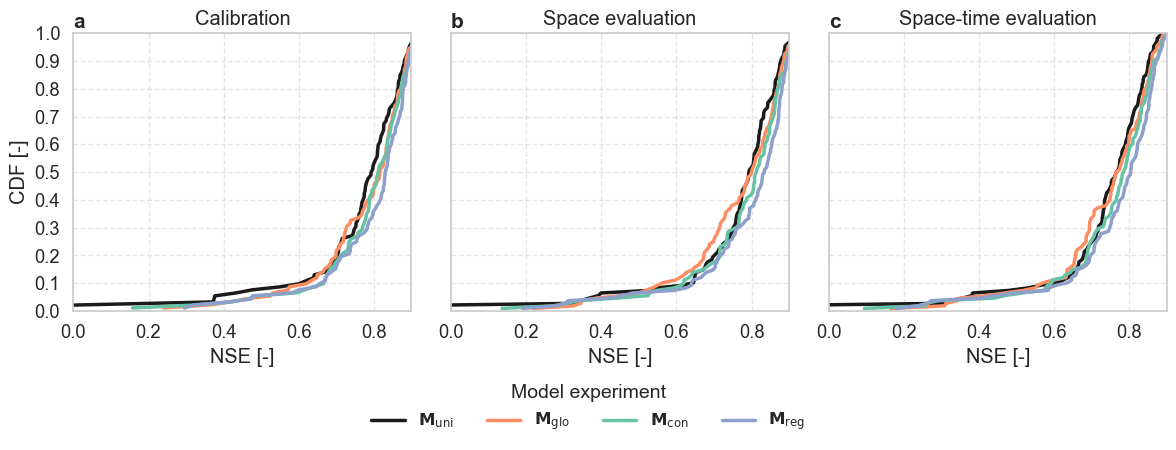

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

# Plotting function
def plot_cdf_mean(ax, data_input, title, label_letter):
    # Check if input is a dict or DataFrame
    if isinstance(data_input, dict):
        dfs = list(data_input.values())
        all_data = pd.concat(dfs, axis=0)
    elif isinstance(data_input, pd.DataFrame):
        all_data = data_input.copy()
    else:
        raise ValueError("data_input must be a dict of DataFrames or a single DataFrame.")
    
    data_combined = all_data.groupby(all_data.index).mean()

    for model_type in ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']:
        if model_type not in data_combined.columns:
            continue
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        ax.plot(
            nse_values, cumulative,
            color=colors[model_type],
            linewidth=2.5,
            label=labels_pretty[model_type]
        )

    ax.set_title(title)
    ax.set_xlim(-0.0, 0.9)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("NSE [-]")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    # Subplot label (a, b, c)
    ax.text(0, 1.075, label_letter, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')


# Set styles
sns.set(style="whitegrid", font_scale=1.2)

# Color and label maps
colors = {
    'nse_nogeo': 'k',
    'nse_g1comp': '#fc8d62',
    'nse_c1comp': '#66c2a5',
    'nse_r1comp': '#8da0cb',
}
labels_pretty = {
    'nse_nogeo': r"$\mathbf{M_{\mathrm{uni}}}$",
    'nse_g1comp': r"$\mathbf{M_{\mathrm{glo}}}$",
    'nse_c1comp': r"$\mathbf{M_{\mathrm{con}}}$",
    'nse_r1comp': r"$\mathbf{M_{\mathrm{reg}}}$",
}

# --- FIGURE 1: CDF plots ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Calibration and space validation use dictionaries
plot_cdf_mean(axs[0], data_diff_calibration_complete_dict_plot, "Calibration", "a")
axs[0].set_ylabel("CDF [-]")

plot_cdf_mean(axs[1], data_diff_cal_complete_dict_plot, "Space evaluation", "b")

# Space-time validation uses the DataFrame directly
plot_cdf_mean(axs[2], data_diff_val_complete_dict_plot, "Space-time evaluation", "c")

# Legend shared
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,
           title="Model experiment",
           loc='lower center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=4,
           fontsize=12,
           title_fontsize=14,
           frameon=False)

# Final layout
plt.tight_layout()
plt.savefig(
    "../results/figs/three_cdfs.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


#### Get some values from CDF

In [21]:
def get_mean_cdf_dataframe(data_input, phase_name):
    # Accept dict of DataFrames or a single DataFrame
    if isinstance(data_input, dict):
        dfs = list(data_input.values())
        all_data = pd.concat(dfs, axis=0)
    elif isinstance(data_input, pd.DataFrame):
        all_data = data_input.copy()
    else:
        raise ValueError("data_input must be a dict of DataFrames or a single DataFrame.")

    data_combined = all_data.groupby(all_data.index).median()

    cdf_dict = {}
    for model_type in ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']:
        if model_type not in data_combined.columns:
            continue
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        df_model = pd.DataFrame({
            'NSE': nse_values,
            'CDF': cumulative
        })
        cdf_dict[model_type] = df_model

    return pd.concat(cdf_dict, names=["Model"])


In [22]:
cdf_cal = get_mean_cdf_dataframe(data_diff_calibration_complete_dict_plot, "Calibration")
cdf_val = get_mean_cdf_dataframe(data_diff_cal_complete_dict_plot, "Space validation")
cdf_valst = get_mean_cdf_dataframe(data_diff_val_complete_dict_plot, "Space-time validation")

In [24]:
# Space validation results
print(cdf_val.loc["nse_nogeo"][cdf_val.loc["nse_nogeo"].CDF > 0.499].head(1))
print(cdf_val.loc["nse_g1comp"][cdf_val.loc["nse_g1comp"].CDF > 0.499].head(1))
print(cdf_val.loc["nse_c1comp"][cdf_val.loc["nse_c1comp"].CDF > 0.499499].head(1))
print(cdf_val.loc["nse_r1comp"][cdf_val.loc["nse_r1comp"].CDF > 0.499].head(1))

         NSE  CDF
53  0.792752  0.5
        NSE  CDF
53  0.79997  0.5
         NSE  CDF
53  0.812506  0.5
         NSE  CDF
53  0.833967  0.5


In [25]:
# Space-time validation results
print(cdf_valst.loc["nse_nogeo"][cdf_valst.loc["nse_nogeo"].CDF > 0.499].head(1))
print(cdf_valst.loc["nse_g1comp"][cdf_valst.loc["nse_g1comp"].CDF > 0.499].head(1))
print(cdf_valst.loc["nse_c1comp"][cdf_valst.loc["nse_c1comp"].CDF > 0.499].head(1))
print(cdf_valst.loc["nse_r1comp"][cdf_valst.loc["nse_r1comp"].CDF > 0.499].head(1))

         NSE  CDF
53  0.765583  0.5
         NSE  CDF
53  0.764468  0.5
         NSE  CDF
53  0.784371  0.5
        NSE  CDF
53  0.80313  0.5


In [55]:
# Calibration validation results
print(cdf_cal.loc["nse_nogeo"][cdf_cal.loc["nse_nogeo"].CDF >= 0.5].head(1))
print(cdf_cal.loc["nse_g1comp"][cdf_cal.loc["nse_g1comp"].CDF >= 0.5].head(1))
print(cdf_cal.loc["nse_c1comp"][cdf_cal.loc["nse_c1comp"].CDF >= 0.5].head(1))
print(cdf_cal.loc["nse_r1comp"][cdf_cal.loc["nse_r1comp"].CDF >= 0.5].head(1))

         NSE  CDF
45  0.792666  0.5
         NSE  CDF
45  0.816285  0.5
         NSE  CDF
45  0.811263  0.5
        NSE  CDF
45  0.82983  0.5


In [26]:
print(cdf_valst.loc["nse_nogeo"][cdf_valst.loc["nse_nogeo"].CDF > 0.3].head(1))
print(cdf_valst.loc["nse_g1comp"][cdf_valst.loc["nse_g1comp"].CDF > 0.3].head(1))
print(cdf_valst.loc["nse_c1comp"][cdf_valst.loc["nse_c1comp"].CDF > 0.3].head(1))
print(cdf_valst.loc["nse_r1comp"][cdf_valst.loc["nse_r1comp"].CDF > 0.3].head(1))

         NSE       CDF
32  0.718454  0.305556
        NSE       CDF
32  0.69437  0.305556
         NSE       CDF
32  0.731562  0.305556
         NSE       CDF
32  0.748921  0.305556


In [27]:
print(cdf_val.loc["nse_nogeo"][cdf_val.loc["nse_nogeo"].CDF > 0.3].head(1))
print(cdf_val.loc["nse_g1comp"][cdf_val.loc["nse_g1comp"].CDF > 0.3].head(1))
print(cdf_val.loc["nse_c1comp"][cdf_val.loc["nse_c1comp"].CDF > 0.3].head(1))
print(cdf_val.loc["nse_r1comp"][cdf_val.loc["nse_r1comp"].CDF > 0.3].head(1))

         NSE       CDF
32  0.753839  0.305556
         NSE       CDF
32  0.716393  0.305556
         NSE       CDF
32  0.764822  0.305556
         NSE       CDF
32  0.770236  0.305556


In [29]:
print(cdf_valst.loc["nse_nogeo"][cdf_valst.loc["nse_nogeo"].NSE > 0.7].head(1))
print(cdf_valst.loc["nse_g1comp"][cdf_valst.loc["nse_g1comp"].NSE > 0.7].head(1))
print(cdf_valst.loc["nse_c1comp"][cdf_valst.loc["nse_c1comp"].NSE > 0.7].head(1))
print(cdf_valst.loc["nse_r1comp"][cdf_valst.loc["nse_r1comp"].NSE > 0.7].head(1))

         NSE   CDF
26  0.700399  0.25
         NSE       CDF
36  0.705223  0.342593
         NSE       CDF
27  0.701928  0.259259
         NSE       CDF
22  0.705967  0.212963


### Scatter plots signatures

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/670658938.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


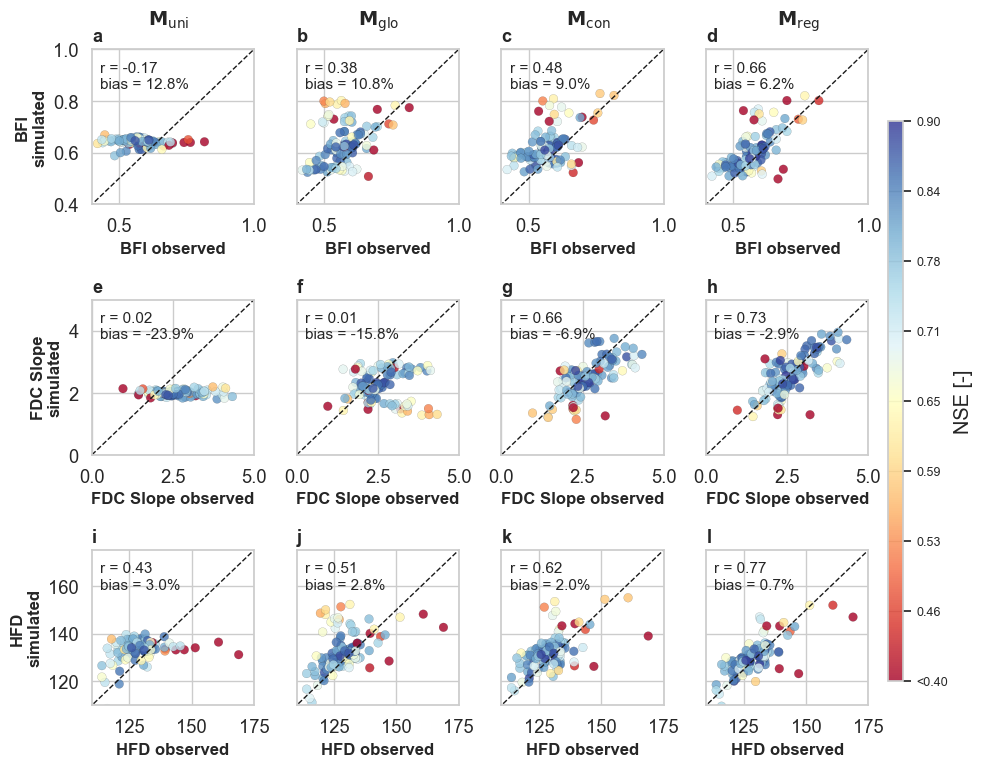

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define variables and pretty titles
metrics = ['bfi', 'slope', 'hfd']
metric_titles = ['BFI', 'FDC Slope', 'HFD']

# Define suffixes and scales
suffixes = ['nogeo', 'g1comp', 'c1comp', 'r1comp']
scale_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Colormap and normalization
cmap = plt.cm.RdYlBu
vmin, vmax = 0.4, 0.9
norm = Normalize(vmin=vmin, vmax=vmax)

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(10, 8), sharex=False, sharey=False)
letters = list(string.ascii_lowercase)

# For shared colorbar, store one scatter artist
scatter_for_colorbar = None

# Loop through rows and columns
for row, (metric, row_title) in enumerate(zip(metrics, metric_titles)):
    for col, (suffix, scale_title) in enumerate(zip(suffixes, scale_titles)):
        ax = axs[row, col]
        var_obs = f"{metric}_obs"
        var_pred = f"{metric}_{suffix}"
        var_nse = f"nse_{suffix}"

        # Color values clipped to [0.5, 0.9]
        colors = data_diff_val_complete[var_nse].clip(lower=vmin, upper=vmax)

        # Scatterplot
        sc = ax.scatter(
            data_diff_val_complete[var_obs],
            data_diff_val_complete[var_pred],
            c=colors,
            cmap=cmap,
            norm=norm,
            s=40,
            edgecolor='k',
            linewidth=0.1,
            alpha=0.8
        )

        # Store one artist for colorbar
        if scatter_for_colorbar is None:
            scatter_for_colorbar = sc


        # Labels
        if col == 0:
            ax.set_ylabel(f"{row_title}\nsimulated", fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel("")
            ax.set_yticklabels("")

        ax.set_xlabel(f"{row_title} observed", fontsize=12, fontweight='bold')

        # Correlation
        R = data_diff_val_complete[[var_obs, var_pred]].corr(method="pearson").iloc[0, 1]
        # Relative bias (percent)
        bias_rel = 100 * (data_diff_val_complete[var_pred].mean() - data_diff_val_complete[var_obs].mean()) / data_diff_val_complete[var_obs].mean()

        # Annotate both r and relative bias
        ax.text(
            0.05, 0.75, f"r = {R:.2f}\nbias = {bias_rel:.1f}%", 
            transform=ax.transAxes,
            fontsize=11,
            bbox=dict(facecolor='none', alpha=0.6, edgecolor='none')
        )

        # Subplot label
        subplot_idx = row * 4 + col
        ax.text(
            -0.00, 1.14, f"{letters[subplot_idx]}", transform=ax.transAxes,
            fontsize=13, fontweight='bold', va='top', ha='left'
        )

        # Set axis limits per metric
        if metric == 'bfi':
            ax.set_xlim(0.4, 1)
            ax.set_ylim(0.4, 1)
        elif metric == 'slope':
            ax.set_xlim(0, 5)
            ax.set_ylim(0, 5)
        elif metric == 'hfd':
            ax.set_xlim(110, 175)
            ax.set_ylim(110, 175)

axs[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 2].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 3].plot([0, 1], [0, 1], 'k--', lw=1)

axs[1, 0].plot([0, 5], [0, 5], 'k--', lw=1)
axs[1, 1].plot([0, 5], [0, 5], 'k--', lw=1)
axs[1, 2].plot([0, 5], [0, 5], 'k--', lw=1)
axs[1, 3].plot([0, 5], [0, 5], 'k--', lw=1)

axs[2, 0].plot([100, 180], [100, 180], 'k--', lw=1)
axs[2, 1].plot([100, 180], [100, 180], 'k--', lw=1)
axs[2, 2].plot([100, 180], [100, 180], 'k--', lw=1)
axs[2, 3].plot([100, 180], [100, 180], 'k--', lw=1)


# Add single vertical colorbar to the right
fig.subplots_adjust(right=0.88)  # Make room for colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter_for_colorbar, cax=cbar_ax)
cbar.set_label("NSE [-]")
cbar.ax.tick_params(labelsize=9)



# Custom ticks and labels
ticks = np.linspace(0.4, 0.9, num=9)  # Adjust number of ticks if needed
tick_labels = [f"<0.40"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.90"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

# Column titles (below x-axis)
col_positions = [0.18, 0.39, 0.6, 0.81]
for x, title in zip(col_positions, scale_titles):
    fig.text(x, 0.99, title, ha='center', va='top', fontsize=14, fontweight='bold')

# Final layout
plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.88)

# Optional save
plt.savefig("../results/figs/signatures_colorbar.png", dpi=300)

plt.show()

In [ ]:
# Check the location of such gauges
data_diff_val_complete[data_diff_val_complete.slope_g1comp < 2.5][data_diff_val_complete.slope_obs > 3]

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/1791010137.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_diff_val_complete[data_diff_val_complete.slope_g1comp < 2.5][data_diff_val_complete.slope_obs > 3]


nse_nogeo  nse_g1comp  nse_c1comp  nse_r1comp   bfi_obs  bfi_r1comp  \
LU000001   0.818454    0.649280    0.881554    0.884523  0.549832    0.543200   
FR000185   0.360620    0.304650    0.253292    0.261731  0.537419    0.771846   
DERP2004   0.780371    0.697834    0.847188    0.854621  0.500677    0.561742   
FR000124   0.772476    0.753625    0.811396    0.807491  0.484187    0.522532   
BEWA0067   0.729356    0.660304    0.793928    0.817378  0.451975    0.551294   
LU000008   0.687396    0.559989    0.719317    0.716055  0.506018    0.543964   
LU000005   0.802608    0.704688    0.852507    0.865122  0.516618    0.561979   
BEWA0106   0.712345    0.527460    0.794958    0.805361  0.500697    0.553869   
DERP2031   0.815352    0.761942    0.844691    0.845447  0.589874    0.568903   
LU000011   0.813974    0.651633    0.865808    0.864817  0.565311    0.565904   
BEWA0107   0.719270    0.566720    0.767076    0.761582  0.579033    0.563482   
BEWA0119   0.779970    0.667152    0.835026    0.844783  0.516294    0.560761   
LU000019   0.789412    0.722665    0.835618    0.849286  0.495707    0.562466   
LU000015   0.774934    0.611168    0.840034    0.849452  0.522385    0.553755   
BEWA0066   0.799494    0.685602    0.865810    0.878786  0.518846    0.560013   

          bfi_c1comp  bfi_g1comp  bfi_nogeo     hfd_obs  ...  slope_obs  \
LU000001    0.574273    0.782482   0.638770  121.500000  ...   3.860265   
FR000185    0.765778    0.733329   0.644075  139.428571  ...   3.200160   
DERP2004    0.587207    0.713699   0.649224  125.480000  ...   3.098546   
FR000124    0.525490    0.621379   0.596098  114.000000  ...   3.097078   
BEWA0067    0.578556    0.695457   0.639020  123.733333  ...   3.529336   
LU000008    0.575109    0.783551   0.640208  119.500000  ...   4.085803   
LU000005    0.586650    0.733425   0.648080  125.166667  ...   3.044633   
BEWA0106    0.587887    0.793989   0.653594  127.695652  ...   4.063630   
DERP2031    0.565357    0.720148   0.632464  133.640000  ...   3.030520   
LU000011    0.591474    0.794881   0.656690  131.333333  ...   3.247142   
BEWA0107    0.588109    0.790302   0.647687  127.086957  ...   3.418620   
BEWA0119    0.586426    0.735354   0.647656  120.409091  ...   3.335934   
LU000019    0.587338    0.709194   0.649611  126.416667  ...   3.429158   
LU000015    0.582595    0.788786   0.647896  121.583333  ...   4.331441   
BEWA0066    0.586049    0.738174   0.647146  126.562500  ...   3.400558   

          slope_r1comp  slope_c1comp  slope_g1comp  slope_nogeo  qmean_obs  \
LU000001      3.581864      3.109574      1.340480     1.877873   1.192096   
FR000185      1.338674      1.316292      1.588988     1.954331   0.799352   
DERP2004      3.368437      3.074827      1.651324     1.960362   1.212305   
FR000124      2.873278      2.531944      2.297750     1.840529   3.916104   
BEWA0067      3.314105      2.987025      1.636624     1.937895   1.521927   
LU000008      3.629050      3.139504      1.359124     1.887828   1.140708   
LU000005      3.320812      3.043438      1.575259     1.951596   1.216879   
BEWA0106      3.758909      3.275390      1.486719     2.017512   1.157128   
DERP2031      3.077905      3.399647      1.629237     2.033145   1.110597   
LU000011      3.604373      3.242003      1.428776     1.958154   0.986891   
BEWA0107      3.130403      2.966732      1.378064     1.937272   1.269441   
BEWA0119      3.312778      3.026627      1.558385     1.951935   1.299843   
LU000019      3.378042      3.104822      1.667025     1.968049   1.178308   
LU000015      3.619007      3.182274      1.379809     1.917866   1.074052   
BEWA0066      3.307116      3.008917      1.551416     1.951208   1.358803   

          qmean_r1comp  qmean_c1comp  qmean_g1comp  qmean_nogeo  
LU000001      1.268308      1.264427      1.230602     1.236307  
FR000185      1.127797      1.124773      1.129408     1.130152  
DERP2004      1.298889      1.295819      1.267811     1.268332  

### Threee geological maps

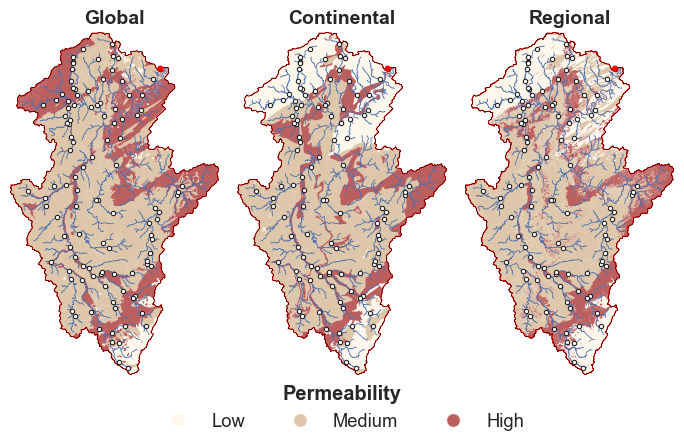

In [217]:
network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index
# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 4))  # Two subplots side by side

# Select multiple geometries
FR_selected_gdf = moselle.copy()

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plot the first geology shapefile with different colors for each class
GLiM_moselle_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='white', markersize=10, edgecolor='k', linewidth=0.75, 
                          label='Measurement Points', zorder=100)

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax1, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=100)

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax1, facecolor='white', edgecolor='red', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_xlabel('')
ax1.set_ylabel('')



# Plot the second geology shapefile with different colors for each class
geology_median_moselle_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='white', markersize=10, edgecolor='k', linewidth=0.75, 
                          label='Measurement Points', zorder=100)

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax2, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=100)
# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(c)', loc="left")
ax2.set_xlabel('')
ax2.set_ylabel('')
custom_label = ["Low", "Medium-low", "Medium-high", "High"]

# Plot the third geology shapefile with different colors for each class
geology_high_moselle_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='white', markersize=10, edgecolor='k', linewidth=0.75, 
                          label='Measurement Points', zorder=100)

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax3, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=100)


# Plot the river
rivers_moselle.plot(ax=ax1, linewidth=0.5, label='River network')
rivers_moselle.plot(ax=ax2, linewidth=0.5, label='River network')
rivers_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='red', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(d)', loc="left")

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    #ax.text(0.45, 1.075, text_to_subplots[i], transform=ax.transAxes, 
    #        fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    ax.set_title(text_to_subplots[i], loc="center", fontsize=14, fontweight="bold")
    i = i + 1

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Adjust the layout to remove extra space
plt.tight_layout()

fig.savefig("../results/figs/fig_geologies.png", dpi=300, bbox_inches='tight')

### NSEs with the three geological maps in background

#### Space-time evaluation

In [38]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<=0.55].loc[:, ["nse_r1comp", "nse_c1comp", "nse_g1comp", "nse_nogeo"]]

nse_r1comp  nse_c1comp  nse_g1comp  nse_nogeo
FR000183    0.483997    0.472558    0.473750   0.391630
FR000185    0.261731    0.253292    0.304650   0.360620
FR000144    0.250477    0.107801    0.136366  -0.190943
FR003280    0.410790    0.453967    0.431325   0.535879
DERP2013    0.500465    0.571146    0.336643  -0.454676
FR003259    0.282321    0.289515    0.347609   0.329937
FR003250    0.231655    0.280377    0.425633   0.392146

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_83009/2773248944.py:89: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_83009/2773248944.py:91: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_83009/2773248944.py:93: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_83009/2773248944.py:181: U

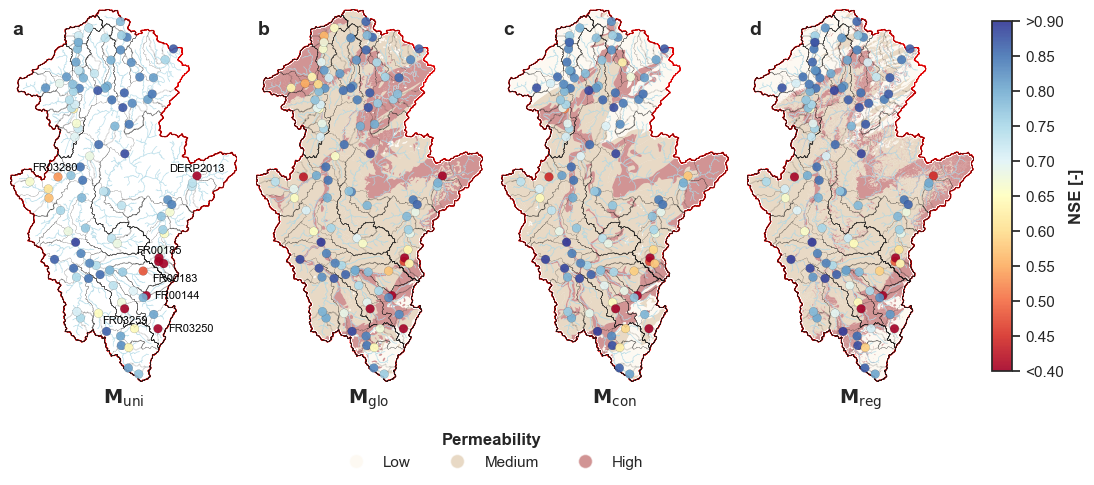

In [77]:
catchment_boundaries_moselle = catchment_boundaries.loc[network_estreams_gdf.index.tolist(), :]

selected_ids = ["DERP2013", "FR000144", "FR000183", "FR000185", "FR003250", "FR003259","FR003280"]


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines


network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set style
sns.set_theme(style="ticks")

# Copy and add coordinates
df = data_diff_val_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# NSE columns and titles
nse_cols = ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']
titles = ['a', 'b', 'c', 'd']
main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

background_maps = ['none', 'GLiM', 'median', 'high']

# Set plot limits to the bounding box of the selected study areas
FR_selected_gdf = moselle.copy()
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

## Create a mask that covers the entire plotting area
#plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
#mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Color setup
vmin, vmax = 0.4, 0.9
cmap_nse = plt.cm.RdYlBu

# Plot loop
for ax, col, subtitle, maintitle, bg_type in zip(axes, nse_cols, titles, main_titles, background_maps):

    # Add background geology map where appropriate
    if bg_type == 'GLiM':
        GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)
    elif bg_type == 'median':
        geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)
    elif bg_type == 'high':
        geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

    # Add rivers and boundary for all
    moselle.plot(ax=ax, color='none', linewidth=2, alpha=1)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

#   if bg_type != 'none':
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25)
    mask.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.75)

    # Scatter NSE values
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot letter
    ax.text(0.01, 0.97, subtitle, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(maintitle, fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)


    catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1, label='Sub-catchments')



# Colorbar setup
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')
ticks = np.linspace(0.4, 0.9, num=11)
tick_labels = [f"<0.40"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f">0.90"]
#cbar.set_ticks(ticks)
cbar.set_ticks(np.arange(vmin, vmax + 0.05, 0.05))

cbar.set_ticklabels(tick_labels)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.5),
    'Medium': to_rgba('tan', 0.5),
    'High': to_rgba('brown', 0.5)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, linewidth=0.5)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')


axes[0].text(7.419000,49.27, "DERP2013", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.014472,48.7, "FR00185", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.18,48.5, "FR00183", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.2,48.38, "FR00144", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.35,48.15, "FR03250", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(6.645964,48.21, "FR03259", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(5.9,49.28, "FR03280", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
	
# Save and show
plt.tight_layout()

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/fig_4geomaps.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

#### Calibration

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:86: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:88: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:90: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:176

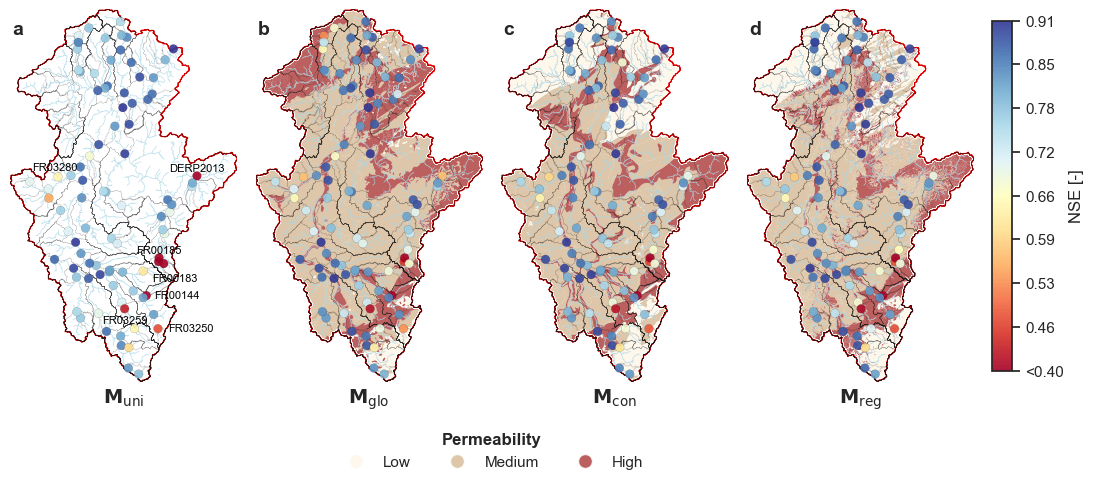

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines


network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set style
sns.set_theme(style="ticks")

# Copy and add coordinates
df = data_diff_calibration_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# NSE columns and titles
nse_cols = ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']
titles = ['a', 'b', 'c', 'd']
main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

background_maps = ['none', 'GLiM', 'median', 'high']

# Set plot limits to the bounding box of the selected study areas
FR_selected_gdf = moselle.copy()
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

## Create a mask that covers the entire plotting area
#plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
#mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Color setup
vmin, vmax = 0.40, 0.91
cmap_nse = plt.cm.RdYlBu

# Plot loop
for ax, col, subtitle, maintitle, bg_type in zip(axes, nse_cols, titles, main_titles, background_maps):

    # Add background geology map where appropriate
    if bg_type == 'GLiM':
        GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'median':
        geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'high':
        geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

    # Add rivers and boundary for all
    moselle.plot(ax=ax, color='none', linewidth=2, alpha=1)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

#   if bg_type != 'none':
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25)
    mask.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.75)

    # Scatter NSE values
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot letter
    ax.text(0.01, 0.97, subtitle, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(maintitle, fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)


    catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1, label='Sub-catchments')



# Colorbar setup
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')
ticks = np.linspace(0.40, 0.91, num=9)
tick_labels = [f"<0.40"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.91"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')


axes[0].text(7.419000,49.27, "DERP2013", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.014472,48.7, "FR00185", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.18,48.5, "FR00183", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.2,48.38, "FR00144", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.35,48.15, "FR03250", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(6.645964,48.21, "FR03259", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(5.9,49.28, "FR03280", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
	
# Save and show
plt.tight_layout()

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/fig_4geomaps_cal.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

#### Space evaluation

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:89: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:91: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:93: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:179: Us

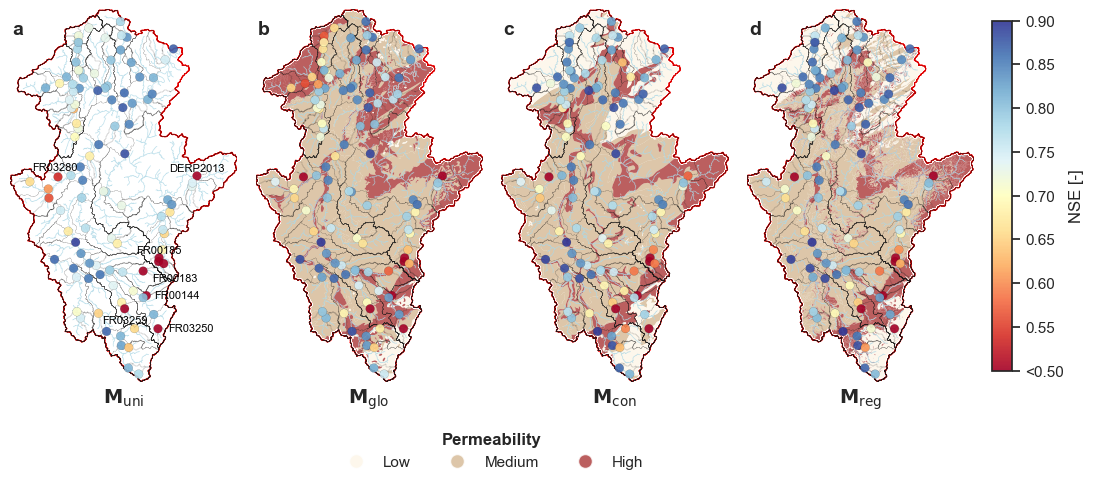

In [207]:
selected_ids = ["DERP2013", "FR000144", "FR000183", "FR000185", "FR003250", "FR003259","FR003280"]


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines


network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set style
sns.set_theme(style="ticks")

# Copy and add coordinates
df = data_diff_cal_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# NSE columns and titles
nse_cols = ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']
titles = ['a', 'b', 'c', 'd']
main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

background_maps = ['none', 'GLiM', 'median', 'high']

# Set plot limits to the bounding box of the selected study areas
FR_selected_gdf = moselle.copy()
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

## Create a mask that covers the entire plotting area
#plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
#mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Color setup
vmin, vmax = 0.5, 0.9
cmap_nse = plt.cm.RdYlBu

# Plot loop
for ax, col, subtitle, maintitle, bg_type in zip(axes, nse_cols, titles, main_titles, background_maps):

    # Add background geology map where appropriate
    if bg_type == 'GLiM':
        GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'median':
        geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'high':
        geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

    # Add rivers and boundary for all
    moselle.plot(ax=ax, color='none', linewidth=2, alpha=1)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

#   if bg_type != 'none':
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25)
    mask.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.75)

    # Scatter NSE values
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot letter
    ax.text(0.01, 0.97, subtitle, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(maintitle, fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)


    catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1, label='Sub-catchments')



# Colorbar setup
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')
ticks = np.linspace(0.5, 0.9, num=9)
tick_labels = [f"<0.50"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.90"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')


axes[0].text(7.419000,49.27, "DERP2013", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.014472,48.7, "FR00185", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.18,48.5, "FR00183", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.2,48.38, "FR00144", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.35,48.15, "FR03250", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(6.645964,48.21, "FR03259", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(5.9,49.28, "FR03280", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
	
# Save and show
plt.tight_layout()

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/fig_4geomaps_space.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

In [209]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.55][["nse_r1comp", "nse_nogeo"]]

nse_r1comp  nse_nogeo
FR000183    0.483997   0.391630
FR000185    0.261731   0.360620
FR000144    0.250477  -0.190943
FR003280    0.410790   0.535879
DERP2013    0.500465  -0.454676
FR003259    0.282321   0.329937
FR003250    0.231655   0.392146

### Catchments with the lowest performance

#### Some analysis

In [120]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.5][["nse_r1comp", "nse_nogeo"]]


nse_r1comp  nse_nogeo
FR000183    0.488465   0.381274
FR000185    0.263676   0.356058
FR000144    0.235977  -0.214744
FR003280    0.402323   0.531344
DERP2013    0.443957  -0.506631
FR003259    0.272996   0.323611
FR003250    0.181581   0.382867

In [121]:
estreams_attributes.loc[["FR000183","FR000185", "FR000144", "FR003280", "DERP2013", "FR003259", "FR003250"], ["frac_snow", "sno_cov_mean", "root_dep_mean",'soil_fra_sand_mean',
       'soil_fra_silt_mean', 'soil_fra_clay_mean', 'soil_fra_grav_mean', "bedrk_dep", "hfd_mean"]]

frac_snow  sno_cov_mean  root_dep_mean  soil_fra_sand_mean  \
basin_id                                                               
FR000183      0.042         5.440         93.143              71.914   
FR000185      0.043         5.536         92.353              68.257   
FR000144      0.047         7.244         79.831              76.475   
FR003280      0.036         2.491        103.243              30.568   
DERP2013      0.039         3.575        116.881              39.495   
FR003259      0.041         3.622        128.125              51.312   
FR003250      0.075        11.555         89.701              73.896   

          soil_fra_silt_mean  soil_fra_clay_mean  soil_fra_grav_mean  \
basin_id                                                               
FR000183              16.614              11.471               7.014   
FR000185              18.866              12.877               7.235   
FR000144              15.559               7.966               5.483   
FR003280              33.054              36.378               8.878   
DERP2013              35.219              25.285               9.293   
FR003259              24.641              24.047               6.672   
FR003250              16.537               9.567               7.597   

          bedrk_dep  hfd_mean  
basin_id                       
FR000183      0.887   152.760  
FR000185      0.912   145.097  
FR000144      0.917   172.085  
FR003280      1.248   148.667  
DERP2013      1.017   166.582  
FR003259      1.009   136.647  
FR003250      0.802   156.082

In [126]:
estreams_attributes_clipped_filters.bedrk_dep.describe()

count    112.000000
mean       1.269929
std        0.543463
min        0.691000
25%        1.024250
50%        1.111500
75%        1.247250
max        4.694000
Name: bedrk_dep, dtype: float64

In [127]:
estreams_attributes_clipped_filters.sno_cov_mean.describe()

count    112.000000
mean       4.879259
std        2.027789
min        2.060000
25%        3.188000
50%        4.614000
75%        6.350000
max       11.555000
Name: sno_cov_mean, dtype: float64

In [128]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.55][["nse_r1comp","nse_g1comp", "nse_nogeo", "bfi_obs", "bfi_r1comp"]]

nse_r1comp  nse_g1comp  nse_nogeo   bfi_obs  bfi_r1comp
FR000183    0.488465    0.468859   0.381274  0.740801    0.729413
FR000185    0.263676    0.308589   0.356058  0.537419    0.762668
FR000144    0.235977    0.165087  -0.214744  0.698369    0.801613
FR003280    0.402323    0.422430   0.531344  0.665425    0.498500
DERP2013    0.443957    0.348807  -0.506631  0.816544    0.801445
FR003259    0.272996    0.343248   0.323611  0.576604    0.726737
FR003250    0.181581    0.311894   0.382867  0.685264    0.535945

In [129]:
len(data_diff_val_complete[data_diff_val_complete.nse_r1comp>0.5])/108

0.9351851851851852

In [134]:
estreams_attributes_clipped_filters.loc[["DERP2013", "FR003280", "FR003250", "FR000185", "FR003259"]][["root_dep_mean", "perm_low_regi", "perm_high_regi", "perm_high_glob2", "perm_low_glob2"]]

root_dep_mean  perm_low_regi  perm_high_regi  perm_high_glob2  \
basin_id                                                                  
DERP2013        116.881            0.0            91.0             92.0   
FR003280        103.243            0.0             0.0              0.0   
FR003250         89.701           96.0             4.0              0.0   
FR000185         92.353            2.0            75.0             71.0   
FR003259        128.125            0.0            66.0             35.0   

          perm_low_glob2  
basin_id                  
DERP2013             0.0  
FR003280             0.0  
FR003250            94.0  
FR000185             2.0  
FR003259             0.0

In [135]:
network_estreams.loc[data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.5].index.tolist()]


gauge_id                                         gauge_name  \
basin_id                                                                  
FR000183  A900105050                                           A9001050   
FR000185  A902101060                                           A9021050   
FR000144  A623201001                                           A6232010   
FR003280  A832201001                                 Le Woigot Ã  Briey   
DERP2013  2642030800                                            Contwig   
FR003259  A664031002  L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...   
FR003250  A600101001                               La Meurthe Ã  Fraize   

         gauge_country gauge_provider  \
basin_id                                
FR000183            FR   FR_EAUFRANCE   
FR000185            FR   FR_EAUFRANCE   
FR000144            FR   FR_EAUFRANCE   
FR003280            FR   FR_EAUFRANCE   
DERP2013            DE          DE_RP   
FR003259            FR   FR_EAUFRANCE   
FR003250            FR   FR_EAUFRANCE   

                                                 river  lon_snap   lat_snap  \
basin_id                                                                      
FR000183           La Sarre à Laneuveville-lès-Lorquin  7.008689  48.654579   
FR000185                         La Sarre à Hermelange  7.014472  48.680322   
FR000144         La Plaine à Raon-l'Étape [La Trouche]  6.877879  48.416320   
FR003280                             Le Woigot à Briey  5.933378  49.246953   
DERP2013                                   Schwarzbach  7.419000  49.254000   
FR003259  L'Arentèle à Saint-Gorgon et à Sainte-Hélène  6.645964  48.324169   
FR003250                           La Meurthe à Fraize  7.002529  48.184730   

               lon        lat elevation  ...  num_continuous_days  \
basin_id                                 ...                        
FR000183  7.008689  48.654579       268  ...                 5322   
FR000185  7.014472  48.680322       258  ...                 4108   
FR000144  6.877879  48.416320       290  ...                11494   
FR003280  5.933378  49.246953       204  ...                15790   
DERP2013  7.419000  49.254000       NaN  ...                24532   
FR003259  6.645964  48.324169       295  ...                 4268   
FR003250  7.002529  48.184730       498  ...                 7524   

          num_days_gaps  num_days_reliable  num_days_noflag num_days_suspect  \
basin_id                                                                       
FR000183          399.0            19568.0             62.0            120.0   
FR000185         1711.0            13759.0              0.0             22.0   
FR000144          179.0            19423.0              0.0             29.0   
FR003280           39.0            19517.0            818.0            188.0   
DERP2013          101.0                0.0          25162.0              0.0   
FR003259           64.0             6737.0              0.0            275.0   
FR003250          192.0            18280.0              0.0            606.0   

         gauge_flag  duplicated_suspect  watershed_group  gauges_upstream  \
basin_id                                                                    
FR000183          A                 NaN                1                1   
FR000185          D          [FR003292]                1                3   
FR000144          A                 NaN                1                1   
FR003280          B                 NaN                1                3   
DERP2013          B                 NaN                1                1   
FR003259          A                 NaN                1                2   
FR003250          A                 NaN                1                1   

                       nested_catchments  
basin_id                                  
FR000183                      [FR000183]  
FR000185  [FR000183, FR000184, FR000185]  
FR000144                      [FR000144]  
FR

#### Plot of the hydrographs

In [153]:
# Base directory and group names
base_dir = Path("../results/sim/space-time")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.median(dim="group")

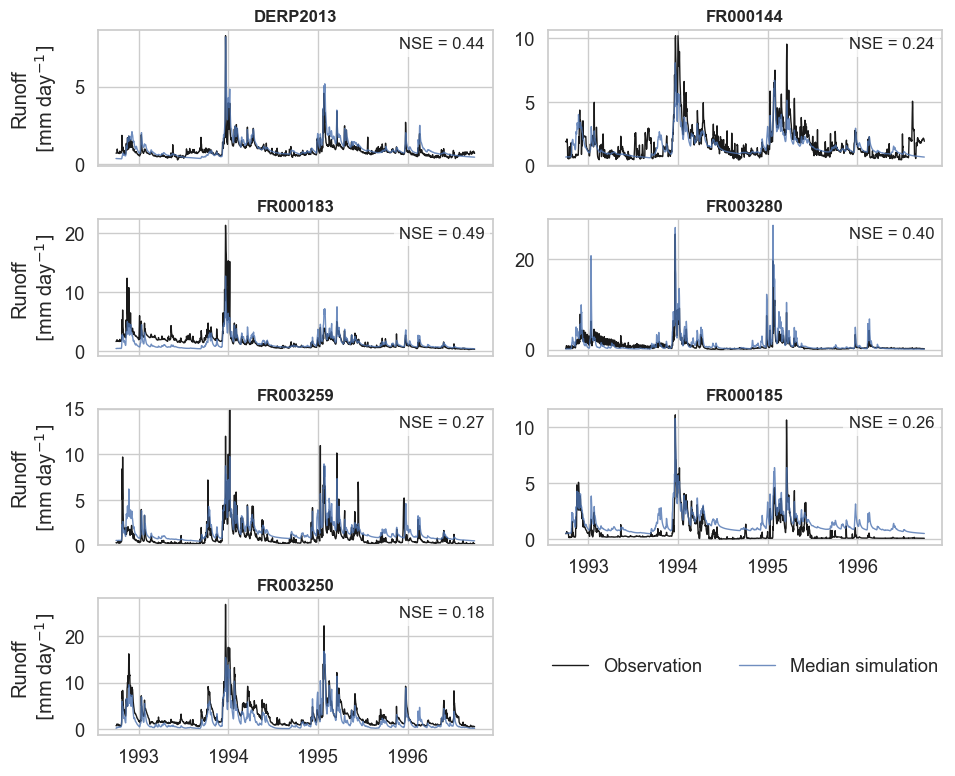

In [154]:
import matplotlib.pyplot as plt

# Define parameters
gauge_ids = ["DERP2013", "FR000144", "FR000183", "FR003280", "FR003259", "FR000185","FR003250"]  # Your 6 gauge IDs
start_date = "1992-10-01"
end_date = "1996-09-30"

# Create subplots (2 columns × 3 rows)
fig, axes = plt.subplots(4, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()  # Flatten to easily loop

# Plot each hydrograph
for i, gauge_id in enumerate(gauge_ids):
    ax = axes[i]
    
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    # Plot observation and regional simulation
    ax.plot(ts.date, ts["observation"], label="Observation", linewidth=1.0, color="k")
    ax.plot(ts.date, ts["regional"], label="Regional", linewidth=1.0, alpha=0.8)
    
    ax.set_title(f"{gauge_id}", fontsize=12, fontweight="bold")
    #ax.set_ylim(0, 20)
    ax.grid(True)

    if i % 2 == 0:  # Left column
        ax.set_ylabel("Runoff\n$[$mm day$^{-1}]$")

    # Get NSE value (rounded for display)
    nse = data_diff_val_complete.loc[gauge_id, "nse_r1comp"]
    nse_label = f"NSE = {nse:.2f}"
    
    # Add NSE label inside the plot (top-right corner)
    ax.text(
        0.98, 0.95, nse_label,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=12,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    #if i == 5:
    #    ax.set_xticklabels(["1990", "1992", "1994", "1996", "1998", "2000"])



#axes[0].set_ylim(0, 10)
#axes[1].set_ylim(0, 10)
axes[4].set_ylim(0, 15)


main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Use last subplot for legend
legend_ax = axes[-1]
legend_ax.axis("off")

# Custom legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Observation", r"Median simulation"]

legend_ax.legend(
    handles, labels,
    loc="center",
    frameon=False,
    ncol=3
)

import matplotlib.dates as mdates

# Set x-axis ticks to years
for ax in axes[:-1]:  # Skip last subplot used for legend
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axes[5].tick_params(labelbottom=True)  # Force x-tick labels visible


fig.align_ylabels(axes)

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for legend


# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/hydrographs_badNSE.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

#### Performance after 1994

In [155]:
# Parameters
gauge_ids = ["DERP2013", "FR000144", "FR000183", "FR003280", "FR003259", "FR000185", "FR003250"]
start_date = "1995-10-01"
end_date = "2015-09-30"

# Compute and print NSEE per gauge
for gauge_id in gauge_ids:
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))

    # Observations and regional simulation
    observations = ts["observation"].values
    simulation = ts["regional"].values

    # Compute NSEE
    nsee_value = compute_nse(observations, simulation)

    # Print result
    print(f"{gauge_id}: NSEE = {nsee_value:.3f}")

DERP2013: NSEE = 0.553
FR000144: NSEE = 0.104
FR000183: NSEE = 0.779
FR003280: NSEE = 0.458
FR003259: NSEE = 0.196
FR000185: NSEE = 0.336
FR003250: NSEE = 0.120


### Catchments with the highest performance

In [377]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp>0.88][["nse_r1comp","nse_c1comp", "nse_g1comp", "nse_nogeo", "bfi_obs", "bfi_r1comp"]]

nse_r1comp  nse_c1comp  nse_g1comp  nse_nogeo   bfi_obs  bfi_r1comp
LU000001    0.884523    0.881554    0.649280   0.818454  0.549832    0.541392
FR003249    0.892924    0.891078    0.884859   0.866954  0.581528    0.602991
FR000128    0.884267    0.880618    0.832449   0.826265  0.526895    0.551680
FR003241    0.886049    0.884207    0.866354   0.853902  0.575086    0.600708
FR003265    0.900366    0.899369    0.897081   0.891996  0.605153    0.632555
DEBU1957    0.889051    0.888017    0.889836   0.882486  0.607290    0.629697
FR003237    0.899046    0.896788    0.879130   0.867927  0.583372    0.596317
FR000140    0.884409    0.883873    0.872127   0.858613  0.570017    0.604185
DERP2003    0.890121    0.889400    0.851956   0.874557  0.560047    0.582378

In [69]:
data_diff_val_complete.loc[['DERP2011', 'DERP2013', 'DERP2027', 'FR000184', 'FR000201', 'FR003250']]

nse_nogeo  nse_g1comp  nse_c1comp  nse_r1comp   bfi_obs  bfi_r1comp  \
DERP2011   0.796410    0.830064    0.793363    0.818362  0.562614    0.622298   
DERP2013  -0.454676    0.336643    0.571146    0.500465  0.816544    0.807227   
DERP2027   0.761128    0.791102    0.760716    0.769759  0.578469    0.592599   
FR000184   0.335225    0.623459    0.587743    0.620917  0.764557    0.826784   
FR000201   0.727409    0.789981    0.774783    0.786002  0.436507    0.549143   
FR003250   0.392146    0.425633    0.280377    0.231655  0.685264    0.549293   

          bfi_c1comp  bfi_g1comp  bfi_nogeo  hfd_obs  ...  slope_obs  \
DERP2011    0.659665    0.595894   0.649066   129.92  ...   2.012416   
DERP2013    0.819108    0.771225   0.647853   160.76  ...   0.958338   
DERP2027    0.661527    0.593280   0.653474   131.52  ...   1.823202   
FR000184    0.827827    0.779276   0.644843   151.44  ...   1.439657   
FR000201    0.586976    0.540289   0.655680   116.16  ...   3.464184   
FR003250    0.564374    0.655188   0.633475   147.04  ...   1.810170   

          slope_r1comp  slope_c1comp  slope_g1comp  slope_nogeo  qmean_obs  \
DERP2011      2.252475      2.073676      2.225895     2.063100   0.851127   
DERP2013      1.386901      1.301790      1.555445     2.118597   0.762804   
DERP2027      2.647934      2.125812      2.336622     2.043438   1.150596   
FR000184      1.205495      1.154815      1.451579     1.945676   1.346135   
FR000201      2.706693      2.531908      2.779720     2.048432   0.849581   
FR003250      2.935070      2.640790      2.458819     1.833348   2.390766   

          qmean_r1comp  qmean_c1comp  qmean_g1comp  qmean_nogeo  
DERP2011      0.977919      0.980737      0.980479     0.972921  
DERP2013      0.819871      0.821231      0.823370     0.820557  
DERP2027      0.953463      0.954118      0.952190     0.944660  
FR000184      1.145649      1.141432      1.145384     1.147091  
FR000201      0.674314      0.678791      0.683550     0.673594  
FR003250      1.599011      1.582984      1.588207     1.562289  

[6 rows x 24 columns]

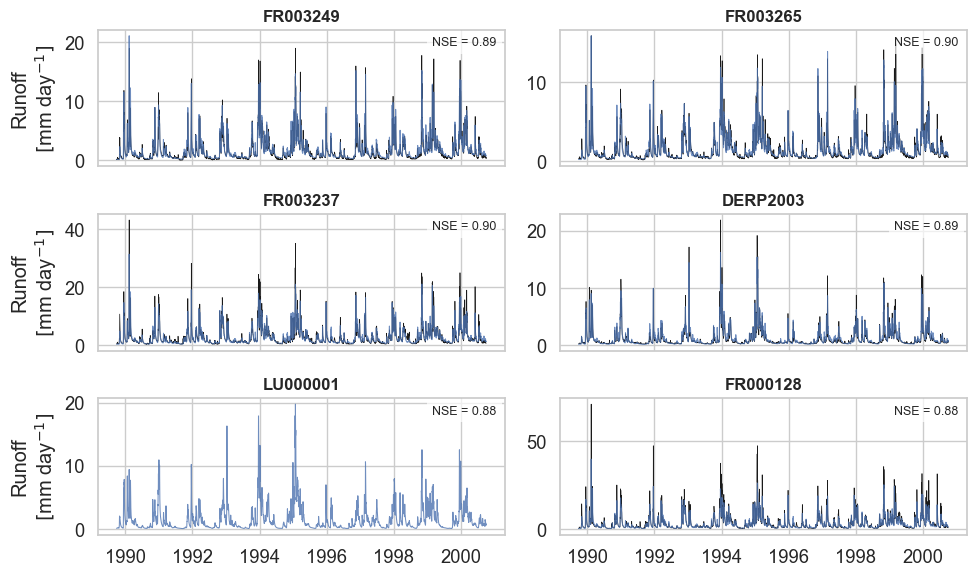

In [77]:
import matplotlib.pyplot as plt

# Define parameters
gauge_ids = ["FR003249", "FR003265", "FR003237", "DERP2003", "LU000001", "FR000128"]  # Your 6 gauge IDs
start_date = "1989-10-01"
end_date = "2000-09-30"

# Create subplots (2 columns × 3 rows)
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()  # Flatten to easily loop

# Plot each hydrograph
for i, gauge_id in enumerate(gauge_ids):
    ax = axes[i]
    
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    # Plot observation and regional simulation
    ax.plot(ts.date, ts["observation"], label="Observation", linewidth=0.5, color="k")
    ax.plot(ts.date, ts["regional"], label="Regional", linewidth=0.75, alpha=0.8)
    
    ax.set_title(f"{gauge_id}", fontsize=12, fontweight="bold")
    #ax.set_ylim(0, 20)
    ax.grid(True)

    if i % 2 == 0:  # Left column
        ax.set_ylabel("Runoff\n$[$mm day$^{-1}]$")

    # Get NSE value (rounded for display)
    nse = data_diff_val_complete.loc[gauge_id, "nse_r1comp"]
    nse_label = f"NSE = {nse:.2f}"
    
    # Add NSE label inside the plot (top-right corner)
    ax.text(
        0.98, 0.95, nse_label,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    #if i == 5:
    #    ax.set_xticklabels(["1990", "1992", "1994", "1996", "1998", "2000"])



#axes[0].set_ylim(0, 10)
#axes[1].set_ylim(0, 10)


main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Use last subplot for legend
#legend_ax = axes[-1]
#legend_ax.axis("off")

# Custom legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Observation", r"Mean simulation"]

legend_ax.legend(
    handles, labels,
    loc="center",
    frameon=False,
    ncol=3
)


fig.align_ylabels(axes)

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for legend


# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/hydrographs_goodNSE.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

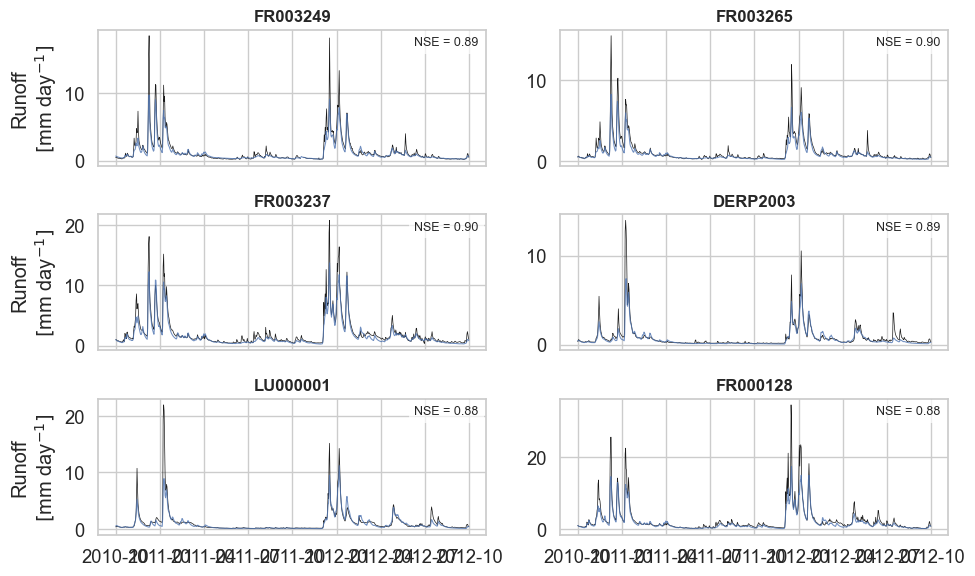

In [386]:
import matplotlib.pyplot as plt

# Define parameters
gauge_ids = ["FR003249", "FR003265", "FR003237", "DERP2003", "LU000001", "FR000128"]  # Your 6 gauge IDs
start_date = "2010-10-01"
end_date = "2012-09-30"

# Create subplots (2 columns × 3 rows)
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()  # Flatten to easily loop

# Plot each hydrograph
for i, gauge_id in enumerate(gauge_ids):
    ax = axes[i]
    
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    # Plot observation and regional simulation
    ax.plot(ts.date, ts["observation"], label="Observation", linewidth=0.5, color="k")
    ax.plot(ts.date, ts["regional"], label="Regional", linewidth=0.75, alpha=0.8)
    
    ax.set_title(f"{gauge_id}", fontsize=12, fontweight="bold")
    #ax.set_ylim(0, 20)
    ax.grid(True)

    if i % 2 == 0:  # Left column
        ax.set_ylabel("Runoff\n$[$mm day$^{-1}]$")

    # Get NSE value (rounded for display)
    nse = data_diff_val_complete.loc[gauge_id, "nse_r1comp"]
    nse_label = f"NSE = {nse:.2f}"
    
    # Add NSE label inside the plot (top-right corner)
    ax.text(
        0.98, 0.95, nse_label,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    #if i == 5:
    #    ax.set_xticklabels(["1990", "1992", "1994", "1996", "1998", "2000"])



#axes[0].set_ylim(0, 10)
#axes[1].set_ylim(0, 10)


main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Use last subplot for legend
#legend_ax = axes[-1]
#legend_ax.axis("off")

# Custom legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Observation", r"Mean simulation"]

legend_ax.legend(
    handles, labels,
    loc="center",
    frameon=False,
    ncol=3
)


fig.align_ylabels(axes)

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for legend


# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/hydrographs_goodNSE_1year.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

### Study area

In [ ]:
catchment_boundaries_moselle = catchment_boundaries.loc[network_estreams_gdf.index.tolist(), :]
world = gpd.read_file(r"/Users/nascimth/Documents/data/gis/world.shp")
lakes = gpd.read_file(r"file:///Users/nascimth/Documents/data/gis/paper_moselle_superflexpy/lakes_moselle.shp")

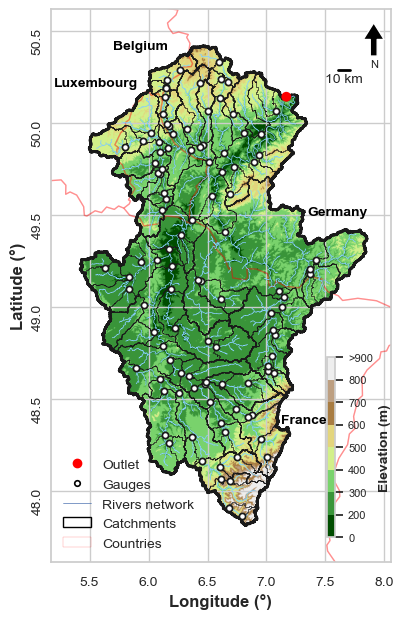

In [212]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

# Define custom terrain colormap without blue
terrain_no_blue_colors = [
    (0.0,  "#004d00"),  # dark green
    (0.25, "#66cc66"),  # light green
    (0.5,  "#ffff99"),  # yellow
    (0.75, "#996633"),  # brown
    (1.0,  "#eeeeee")   # light gray/white
]

terrain_no_blue = LinearSegmentedColormap.from_list("terrain_no_blue", terrain_no_blue_colors)



# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, ax = plt.subplots(figsize=(4, 6))


data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 12           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('white')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

world.plot(ax=ax, color='none', edgecolor='red', linewidth=1, alpha=0.25)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color classes (discrete intervals)
bounds = [0, 200, 300, 400, 500, 600, 700, 800, 900]  # Define class boundaries
cmap = plt.get_cmap(terrain_no_blue)  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.8, 0.12, 0.02, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)

tick_labels = [str(b) for b in bounds[:-1]] + ['>900']
cbar.ax.set_yticklabels(tick_labels)

cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=10)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
#cbar.ax.set_aspect('auto')

# Set the title and show the plot
#ax.set_title('C', loc = "left", fontsize=14, fontweight="bold")

# Plot the river
rivers_moselle.plot(ax=ax, linewidth=0.5, color="lightskyblue")

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax, facecolor='none', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2, label='Sub-catchments')
catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5, label='Sub-catchments')


## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax, color='black', markersize=30, edgecolor='none', linewidth=0.5, 
#                          label='Streamflow gauges', zorder=1000)

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='white', markersize=20, edgecolor='k', linewidth=1.25, 
                          label='Streamflow gauges', zorder=1000)

# Plot the points from network_estreams_filtered
network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax, color='red', markersize=50, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.25, x_max+0.2)
ax.set_ylim(y_min-0.2, y_max+0.2)


ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=12)

# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Catchments')
countries_patch = Patch(facecolor='none', edgecolor='red', lw=0.25, alpha = 0.5, label='Countries')

# For streamflow gauges (as black dots)
#streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=4, label='Gauges')
streamflow_marker = Line2D(
    [0], [0],
    color='none',                # No line connecting markers
    marker='o',                  # Circle marker
    markersize=4,                # Size in points
    markerfacecolor='white',     # Fill color inside the circle
    markeredgecolor='black',     # Color of the circle's edge
    markeredgewidth=1.2,         # Width of the edge
    label='Gauges'
)

# For outlet gauges (as black dots)
outlet_marker = Line2D([0], [0], color='red', lw=0, marker='o', markersize=6, label='Outlet')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers network')

# Add the legend with all items
legend = ax.legend(handles=[outlet_marker, streamflow_marker, river_line, subcatchment_patch, countries_patch], 
                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.95, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=10)

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)

# Adding some text
ax.text(5.7, 50.4, 'Belgium', fontsize=10, color='black', fontweight='bold')
ax.text(5.2, 50.2, 'Luxembourg', fontsize=10, color='black', fontweight='bold')
ax.text(7.35, 49.50, 'Germany', fontsize=10, color='black', fontweight='bold')
ax.text(7.12, 48.37, 'France', fontsize=10, color='black', fontweight='bold')

import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax.set_aspect('equal')
ax.grid(True)
# Adjust the layout to remove extra space
plt.tight_layout(pad=0)

# Save including everything (colorbar + legend)
plt.savefig(
    r"/Users/nascimth/Library/CloudStorage/OneDrive-Eawag/Eawag/Papers/Moselle_superflexpy/GitHub/estreams_superflexpy/results/figs/study_area.png",
    dpi=300,
    bbox_inches='tight'
)
# Show the plot
plt.show()

### Parameters plots

In [ ]:
import re
import os
import glob

def is_valid_key(k):
    # Exclude keys that end in Group_X_2
    
    return not re.search(r'Group_\d+_2$', k)

def is_valid_key_2(k):
    # Include only keys that end in Group_X_2
    return re.search(r'Group_\d+_2$', k)

# Dictionary to store all parameter dicts
all_param_dicts = {}

# Loop through all CSVs in the current directory
for filepath in glob.glob("../results/groups/*moselle*comp*.csv"):
    file_key = os.path.splitext(os.path.basename(filepath))[0]  # Strip .csv
    
    param_dict = {}

    # Read file and parse lines
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(","):  # Skip empty or malformed lines
                continue
            parts = line.split(",")
            if len(parts) == 2:
                key, value = parts
                try:
                    param_dict[key] = float(value)
                except ValueError:
                    pass  # Skip lines where value is not a float
            else:
                pass  # Skip malformed lines

    # Store the parsed dictionary
    all_param_dicts[file_key] = param_dict


regional_keys_2 = [k for k in all_param_dicts if "regi" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]


regional_keys_1 = [k for k in all_param_dicts if "regi" in k and is_valid_key(k)]
continental_keys_1 = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys_1 = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

In [ ]:
#################### Regional parameters
dfs=[]
for key in regional_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

regional_params_2 = pd.concat(dfs)

regional_params_2.high_snow_k = 1/regional_params_2.high_snow_k
regional_params_2.high_slow_k = 1/regional_params_2.high_slow_k
regional_params_2.high_fast_k = 1/regional_params_2.high_fast_k
regional_params_2.general_snow_k = 1/regional_params_2.general_snow_k
regional_params_2.general_slow_k = 1/regional_params_2.general_slow_k
regional_params_2.general_fast_k = 1/regional_params_2.general_fast_k
regional_params_2.low_snow_k = 1/regional_params_2.low_snow_k
regional_params_2.low_slow_k = 1/regional_params_2.low_slow_k
regional_params_2.low_fast_k = 1/regional_params_2.low_fast_k

dfs=[]
for key in regional_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

regional_params_1 = pd.concat(dfs)

regional_params_1.high_snow_k = 1/regional_params_1.high_snow_k
regional_params_1.high_slow_k = 1/regional_params_1.high_slow_k
regional_params_1.high_fast_k = 1/regional_params_1.high_fast_k
regional_params_1.general_snow_k = 1/regional_params_1.general_snow_k
regional_params_1.general_slow_k = 1/regional_params_1.general_slow_k
regional_params_1.general_fast_k = 1/regional_params_1.general_fast_k
regional_params_1.low_snow_k = 1/regional_params_1.low_snow_k
regional_params_1.low_slow_k = 1/regional_params_1.low_slow_k
regional_params_1.low_fast_k = 1/regional_params_1.low_fast_k

#################### Continental parameters
dfs=[]
for key in continental_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

continental_params_2 = pd.concat(dfs)
continental_params_2.high_snow_k = 1/continental_params_2.high_snow_k
continental_params_2.high_slow_k = 1/continental_params_2.high_slow_k
continental_params_2.high_fast_k = 1/continental_params_2.high_fast_k
continental_params_2.general_snow_k = 1/continental_params_2.general_snow_k
continental_params_2.general_slow_k = 1/continental_params_2.general_slow_k
continental_params_2.general_fast_k = 1/continental_params_2.general_fast_k
continental_params_2.low_snow_k = 1/continental_params_2.low_snow_k
continental_params_2.low_slow_k = 1/continental_params_2.low_slow_k
continental_params_2.low_fast_k = 1/continental_params_2.low_fast_k

dfs=[]
for key in continental_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

continental_params_1 = pd.concat(dfs)
continental_params_1.high_snow_k = 1/continental_params_1.high_snow_k
continental_params_1.high_slow_k = 1/continental_params_1.high_slow_k
continental_params_1.high_fast_k = 1/continental_params_1.high_fast_k
continental_params_1.general_snow_k = 1/continental_params_1.general_snow_k
continental_params_1.general_slow_k = 1/continental_params_1.general_slow_k
continental_params_1.general_fast_k = 1/continental_params_1.general_fast_k
continental_params_1.low_snow_k = 1/continental_params_1.low_snow_k
continental_params_1.low_slow_k = 1/continental_params_1.low_slow_k
continental_params_1.low_fast_k = 1/continental_params_1.low_fast_k

#################### Global parameters
dfs=[]
for key in global_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

global_params_2 = pd.concat(dfs)
global_params_2.high_snow_k = 1/global_params_2.high_snow_k
global_params_2.high_slow_k = 1/global_params_2.high_slow_k
global_params_2.high_fast_k = 1/global_params_2.high_fast_k
global_params_2.general_snow_k = 1/global_params_2.general_snow_k
global_params_2.general_slow_k = 1/global_params_2.general_slow_k
global_params_2.general_fast_k = 1/global_params_2.general_fast_k
global_params_2.low_snow_k = 1/global_params_2.low_snow_k
global_params_2.low_slow_k = 1/global_params_2.low_slow_k
global_params_2.low_fast_k = 1/global_params_2.low_fast_k

dfs=[]
for key in global_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

global_params_1 = pd.concat(dfs)
global_params_1.high_snow_k = 1/global_params_1.high_snow_k
global_params_1.high_slow_k = 1/global_params_1.high_slow_k
global_params_1.high_fast_k = 1/global_params_1.high_fast_k
global_params_1.general_snow_k = 1/global_params_1.general_snow_k
global_params_1.general_slow_k = 1/global_params_1.general_slow_k
global_params_1.general_fast_k = 1/global_params_1.general_fast_k
global_params_1.low_snow_k = 1/global_params_1.low_snow_k
global_params_1.low_slow_k = 1/global_params_1.low_slow_k
global_params_1.low_fast_k = 1/global_params_1.low_fast_k


##### Concatenate all parameters
global_params = pd.concat([global_params_1, global_params_2], ignore_index=True)
continental_params = pd.concat([continental_params_1, continental_params_2], ignore_index=True)
regional_params = pd.concat([regional_params_1, regional_params_2], ignore_index=True)

In [ ]:
global_params.describe().T

count        mean         std         min  \
high_snow_k                      14.0    0.351145    0.097880    0.207184   
high_unsaturated_Smax            14.0  149.378877   25.486629  118.598117   
high_unsaturated_Ce              14.0    0.924596    0.204594    0.650398   
high_unsaturated_beta            14.0    1.884026    1.143014    0.666162   
high_lowersplitter_splitpar      14.0    0.557284    0.123225    0.325405   
high_slow_k                      14.0  414.992405  217.008939   39.136182   
high_lag-fun_lag-time            14.0    2.000551    0.038790    1.913164   
high_fast_k                      14.0  216.626620  153.513579   13.101528   
general_snow_k                   14.0    0.351145    0.097880    0.207184   
general_unsaturated_Smax         14.0  149.378877   25.486629  118.598117   
general_unsaturated_Ce           14.0    0.924596    0.204594    0.650398   
general_unsaturated_beta         14.0    1.884026    1.143014    0.666162   
general_lowersplitter_splitpar   14.0    0.203705    0.072551    0.136047   
general_slow_k                   14.0  636.845049  889.207628   28.110677   
general_lag-fun_lag-time         14.0    2.000551    0.038790    1.913164   
general_fast_k                   14.0   52.371118   19.223034   12.151650   
low_snow_k                       14.0    0.351145    0.097880    0.207184   
low_unsaturated_Smax             14.0  149.378877   25.486629  118.598117   
low_unsaturated_Ce               14.0    0.924596    0.204594    0.650398   
low_unsaturated_beta             14.0    1.884026    1.143014    0.666162   
low_lowersplitter_splitpar       14.0    0.736015    0.171865    0.226697   
low_slow_k                       14.0   31.395705   31.947321   10.333201   
low_lag-fun_lag-time             14.0    2.000551    0.038790    1.913164   
low_fast_k                       14.0   52.331220  102.268077    1.009084   

                                       25%         50%         75%  \
high_snow_k                       0.285270    0.329202    0.410635   
high_unsaturated_Smax           129.879036  149.251043  163.251648   
high_unsaturated_Ce               0.757814    0.907233    1.006708   
high_unsaturated_beta             1.060126    1.439852    2.520198   
high_lowersplitter_splitpar       0.484990    0.569601    0.630167   
high_slow_k                     278.445768  393.482408  569.788482   
high_lag-fun_lag-time             1.988692    2.001863    2.010434   
high_fast_k                      62.296712  219.659563  297.306009   
general_snow_k                    0.285270    0.329202    0.410635   
general_unsaturated_Smax        129.879036  149.251043  163.251648   
general_unsaturated_Ce            0.757814    0.907233    1.006708   
general_unsaturated_beta          1.060126    1.439852    2.520198   
general_lowersplitter_splitpar    0.158931    0.190060    0.205454   
general_slow_k                  152.509630  336.647684  670.994886   
general_lag-fun_lag-time          1.988692    2.001863    2.010434   
general_fast_k                   39.889492   52.177604   66.148995   
low_snow_k                        0.285270    0.329202    0.410635   
low_unsaturated_Smax            129.879036  149.251043  163.251648   
low_unsaturated_Ce                0.757814    0.907233    1.006708   
low_unsaturated_beta              1.060126    1.439852    2.520198   
low_lowersplitter_splitpar        0.692057    0.781419    0.850002   
low_slow_k                       12.211885   14.425780   43.182788   
low_lag-fun_lag-time              1.988692    2.001863    2.010434   
low_fast_k                        2.043502    3.043792   51.261604   

                                        max  
high_snow_k                        0.577784  
high_unsaturated_Smax            215.622180  
high_unsaturated_Ce                1.302126  
high_unsaturated_beta              4.649047  
high_lowersplitter_splitpar        0.793925  
high_slow_k                      728.251501  
high_lag-fun_lag-time            

In [ ]:
regional_params.describe().T

count         mean          std         min  \
high_snow_k                      14.0     0.401523     0.110479    0.289391   
high_unsaturated_Smax            14.0   138.704359    14.195639  121.526910   
high_unsaturated_Ce              14.0     0.883600     0.161151    0.700266   
high_unsaturated_beta            14.0     1.880376     0.592462    1.062050   
high_lowersplitter_splitpar      14.0     0.639567     0.137759    0.449088   
high_slow_k                      14.0   450.615798   186.662020  194.411978   
high_lag-fun_lag-time            14.0     2.052270     0.046935    1.993162   
high_fast_k                      14.0   242.469791   202.831881    1.689514   
general_snow_k                   14.0     0.401523     0.110479    0.289391   
general_unsaturated_Smax         14.0   138.704359    14.195639  121.526910   
general_unsaturated_Ce           14.0     0.883600     0.161151    0.700266   
general_unsaturated_beta         14.0     1.880376     0.592462    1.062050   
general_lowersplitter_splitpar   14.0     0.196517     0.070647    0.101452   
general_slow_k                   14.0  1201.195282  1916.027090  110.789943   
general_lag-fun_lag-time         14.0     2.052270     0.046935    1.993162   
general_fast_k                   14.0    49.461702    22.342807   23.795617   
low_snow_k                       14.0     0.401523     0.110479    0.289391   
low_unsaturated_Smax             14.0   138.704359    14.195639  121.526910   
low_unsaturated_Ce               14.0     0.883600     0.161151    0.700266   
low_unsaturated_beta             14.0     1.880376     0.592462    1.062050   
low_lowersplitter_splitpar       14.0     0.417141     0.167939    0.149388   
low_slow_k                       14.0    19.191525    15.083866   10.234316   
low_lag-fun_lag-time             14.0     2.052270     0.046935    1.993162   
low_fast_k                       14.0    54.116055    32.581569    6.352938   

                                       25%         50%         75%  \
high_snow_k                       0.340345    0.352717    0.429677   
high_unsaturated_Smax           126.651527  137.954830  147.662423   
high_unsaturated_Ce               0.763014    0.828857    0.963559   
high_unsaturated_beta             1.413189    2.007695    2.299996   
high_lowersplitter_splitpar       0.536639    0.596873    0.766783   
high_slow_k                     308.787148  427.749167  510.026085   
high_lag-fun_lag-time             2.007798    2.052290    2.081602   
high_fast_k                      26.446489  248.787934  382.658635   
general_snow_k                    0.340345    0.352717    0.429677   
general_unsaturated_Smax        126.651527  137.954830  147.662423   
general_unsaturated_Ce            0.763014    0.828857    0.963559   
general_unsaturated_beta          1.413189    2.007695    2.299996   
general_lowersplitter_splitpar    0.143032    0.199077    0.257319   
general_slow_k                  156.142966  244.914529  917.082974   
general_lag-fun_lag-time          2.007798    2.052290    2.081602   
general_fast_k                   33.989749   42.790449   57.466152   
low_snow_k                        0.340345    0.352717    0.429677   
low_unsaturated_Smax            126.651527  137.954830  147.662423   
low_unsaturated_Ce                0.763014    0.828857    0.963559   
low_unsaturated_beta              1.413189    2.007695    2.299996   
low_lowersplitter_splitpar        0.274517    0.454915    0.487839   
low_slow_k                       10.497158   11.831671   16.941912   
low_lag-fun_lag-time              2.007798    2.052290    2.081602   
low_fast_k                       30.027100   51.077068   81.692575   

                                        max  
high_snow_k                        0.649169  
high_unsaturated_Smax            166.053920  
high_unsaturated_Ce                1.248892  
high_unsaturated_beta              3.061847  
high_lowersplitter_splitpar        0.884068  
high_slow_k                  

In [ ]:
continental_params.describe().T

count        mean          std         min  \
high_snow_k                      14.0    0.368060     0.116277    0.164875   
high_unsaturated_Smax            14.0  140.087463    15.696292  114.719363   
high_unsaturated_Ce              14.0    0.899756     0.167209    0.714294   
high_unsaturated_beta            14.0    1.730830     0.528800    0.959812   
high_lowersplitter_splitpar      14.0    0.679269     0.150871    0.457242   
high_slow_k                      14.0  438.366808   266.114071  140.454592   
high_lag-fun_lag-time            14.0    2.020578     0.058665    1.910567   
high_fast_k                      14.0  142.191388   168.407659    1.382251   
general_snow_k                   14.0    0.368060     0.116277    0.164875   
general_unsaturated_Smax         14.0  140.087463    15.696292  114.719363   
general_unsaturated_Ce           14.0    0.899756     0.167209    0.714294   
general_unsaturated_beta         14.0    1.730830     0.528800    0.959812   
general_lowersplitter_splitpar   14.0    0.214879     0.067547    0.101992   
general_slow_k                   14.0  832.281698  1031.310861   15.577694   
general_lag-fun_lag-time         14.0    2.020578     0.058665    1.910567   
general_fast_k                   14.0   61.903857    27.312997   31.150635   
low_snow_k                       14.0    0.368060     0.116277    0.164875   
low_unsaturated_Smax             14.0  140.087463    15.696292  114.719363   
low_unsaturated_Ce               14.0    0.899756     0.167209    0.714294   
low_unsaturated_beta             14.0    1.730830     0.528800    0.959812   
low_lowersplitter_splitpar       14.0    0.376112     0.185644    0.107879   
low_slow_k                       14.0   78.124796   158.654836   10.773033   
low_lag-fun_lag-time             14.0    2.020578     0.058665    1.910567   
low_fast_k                       14.0   77.584192    49.256889   23.556292   

                                       25%         50%          75%  \
high_snow_k                       0.294458    0.354135     0.425105   
high_unsaturated_Smax           124.786880  143.866309   148.938567   
high_unsaturated_Ce               0.768535    0.852640     0.984378   
high_unsaturated_beta             1.236760    1.745294     2.078146   
high_lowersplitter_splitpar       0.550562    0.732294     0.772780   
high_slow_k                     344.809617  369.227722   457.263599   
high_lag-fun_lag-time             1.994421    2.012924     2.049140   
high_fast_k                       5.071720   91.796939   210.908469   
general_snow_k                    0.294458    0.354135     0.425105   
general_unsaturated_Smax        124.786880  143.866309   148.938567   
general_unsaturated_Ce            0.768535    0.852640     0.984378   
general_unsaturated_beta          1.236760    1.745294     2.078146   
general_lowersplitter_splitpar    0.157537    0.219110     0.265320   
general_slow_k                  109.798905  289.418243  1100.680146   
general_lag-fun_lag-time          1.994421    2.012924     2.049140   
general_fast_k                   49.938455   54.465308    61.818072   
low_snow_k                        0.294458    0.354135     0.425105   
low_unsaturated_Smax            124.786880  143.866309   148.938567   
low_unsaturated_Ce                0.768535    0.852640     0.984378   
low_unsaturated_beta              1.236760    1.745294     2.078146   
low_lowersplitter_splitpar        0.221887    0.359508     0.526317   
low_slow_k                       15.736486   23.199204    56.067091   
low_lag-fun_lag-time              1.994421    2.012924     2.049140   
low_fast_k                       36.718729   58.742636   115.589805   

                                        max  
high_snow_k                        0.594094  
high_unsaturated_Smax            162.305497  
high_unsaturated_Ce                1.260205  
high_unsaturated_beta              2.457484  
high_lowersplitter_splitpar        0.898853  
high_slow_k                  

#### Figure without log axis

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/3897176078.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/3897176078.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/3897176078.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/3897176078.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

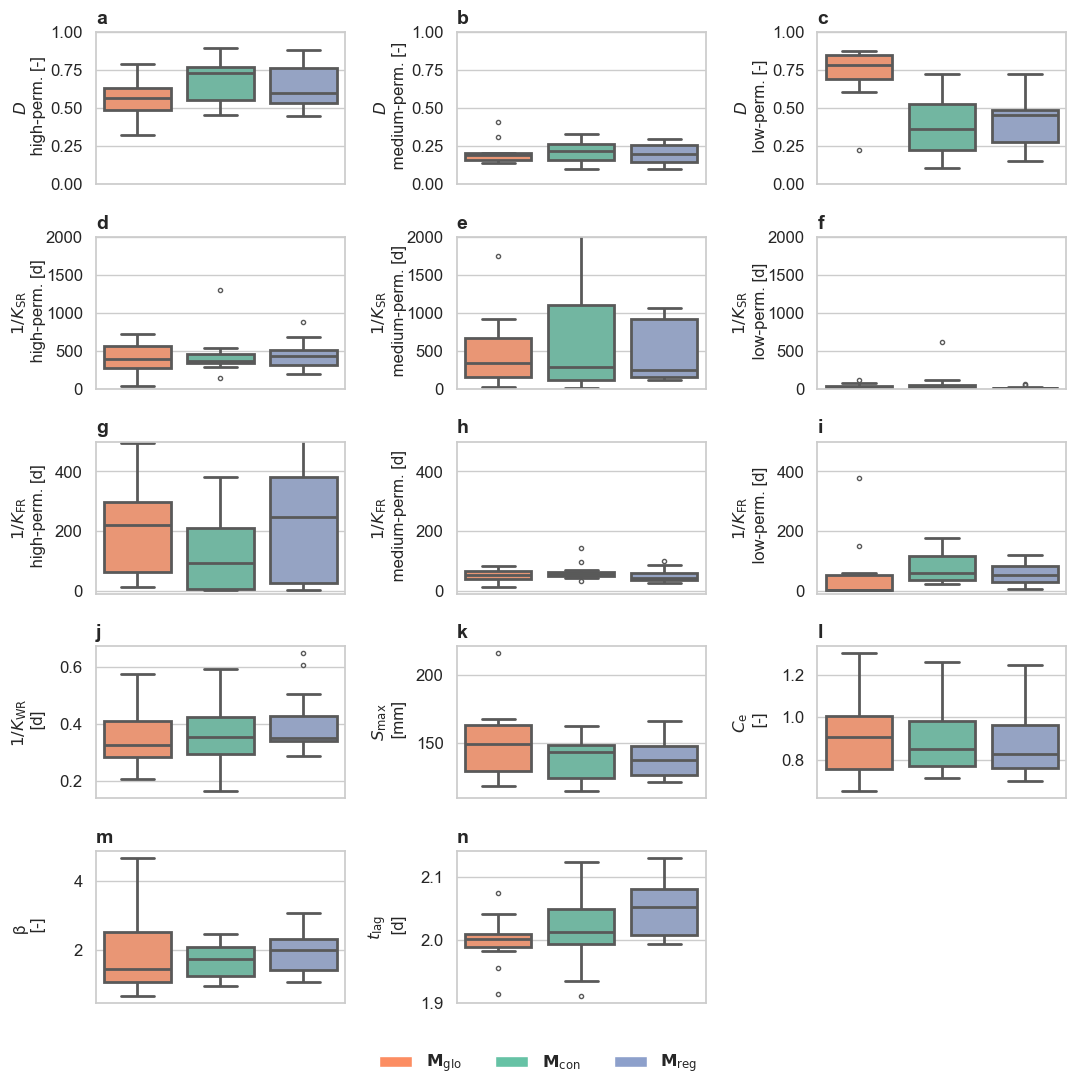

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch


subplot_titles = list("abcdefghijklmnopqrstu")  # Enough for 26 variables


# Seaborn styling
sns.set_theme(style="whitegrid", font_scale=1.2)

# Prepare long-format data
def prepare_long_df(df, name):
    df_long = df.copy()
    df_long['source'] = name
    return df_long

regional_long = prepare_long_df(regional_params, 'Regional')
continental_long = prepare_long_df(continental_params, 'Continental')
global_long = prepare_long_df(global_params, 'Global')

all_long = pd.concat([global_long, continental_long, regional_long], axis=0)
all_long = all_long.melt(id_vars='source', var_name='variable', value_name='value')

# Colors for groups
palette = {
    'Regional': '#8da0cb',     # blue
    'Continental': '#66c2a5',  # green
    'Global': '#fc8d62'        # orange
}

# Variables to plot
variables = [

    'high_lowersplitter_splitpar', 
    'general_lowersplitter_splitpar',
    'low_lowersplitter_splitpar',

    'high_slow_k',
    'general_slow_k',
    'low_slow_k',
    
    'high_fast_k', 
    'general_fast_k',
    'low_fast_k',

    'high_snow_k', 
    'high_unsaturated_Smax', 
    'high_unsaturated_Ce',
    'high_unsaturated_beta', 
    'high_lag-fun_lag-time',
    ]


# Pretty labels for y-axes
pretty_labels = {

    'general_lowersplitter_splitpar': r'$\mathit{D}$' + '\n medium-perm. [-]',
    'high_lowersplitter_splitpar': r'$\mathit{D}$' + '\n high-perm. [-]',#
    'low_lowersplitter_splitpar': r'$\mathit{D}$' + '\n low-perm. [-]',#
    'high_fast_k': r'$1/\mathit{K}_{\mathrm{FR}}$' + '\n high-perm. [d]',
    'high_slow_k': r'$1/\mathit{K}_{\mathrm{SR}}$' + '\n high-perm. [d]',#
    'general_slow_k': r'$1/\mathit{K}_{\mathrm{SR}}$' + '\n medium-perm. [d]',#
    'general_fast_k': r'$1/\mathit{K}_{\mathrm{FR}}$' + '\n medium-perm. [d]',#
    'low_slow_k': r'$1/\mathit{K}_{\mathrm{SR}}$' + '\n low-perm. [d]',#
    'low_fast_k': r'$1/\mathit{K}_{\mathrm{FR}}$' + '\n low-perm. [d]',#

    'high_snow_k': r'$1/\mathit{K}_{\mathrm{WR}}$' + '\n [d]',#
    'high_unsaturated_Smax': r'$\mathit{S}_{\mathrm{max}}$' + '\n [mm]',
    'high_unsaturated_Ce': r'$\mathit{C}_{\mathrm{e}}$' + '\n [-]',#
    'high_unsaturated_beta': 'β \n [-]',#
    'high_lag-fun_lag-time': r'$\mathit{t}_{\mathrm{lag}}$' + '\n [d]',#


}

# Layout
ncols = 3
nrows = int(np.ceil(len(variables) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 11), sharey=False)
axes = axes.flatten()

# Plot
for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(
        data=all_long[all_long['variable'] == var],
        x='source', y='value',
        palette=palette,
        linewidth=2.0,
        fliersize=3,
        ax=ax
    )
    ax.set_title(subplot_titles[i], fontsize=14, weight='bold', loc="left")  # "A", "B", ...
    ax.set_xlabel('')
    ax.set_ylabel(pretty_labels.get(var, var), fontsize=12)
    ax.set_xticks([])  # remove x-axis group labels
    ax.tick_params(labelsize=12)

# Hide unused axes
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Custom legend
legend_elements = [
    Patch(facecolor=palette['Global'], label=r"$\mathbf{M_{\mathrm{glo}}}$"),
    Patch(facecolor=palette['Continental'], label=r"$\mathbf{M_{\mathrm{con}}}$"),
    Patch(facecolor=palette["Regional"], label=r"$\mathbf{M_{\mathrm{reg}}}$"),
]

axes[0].set_ylim(0, 1)  
axes[1].set_ylim(0, 1)  
axes[2].set_ylim(0, 1)  

axes[3].set_ylim(0, 2000)  
axes[4].set_ylim(0, 2000)  
axes[5].set_ylim(0, 2000)

axes[6].set_ylim(-10, 500)  
axes[7].set_ylim(-10, 500)  
axes[8].set_ylim(-10, 500)  

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=12,
    frameon=False
)

# Align all y-axis labels
for ax in axes:
    ax.yaxis.set_label_coords(-0.2, 0.5)  # adjust -0.15 as needed

#axes[8].set_ylim(-10, 200)
plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.savefig("../results/figs/boxplots_paramS.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

#### Figure with log axis

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/240123970.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/240123970.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/240123970.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/240123970.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

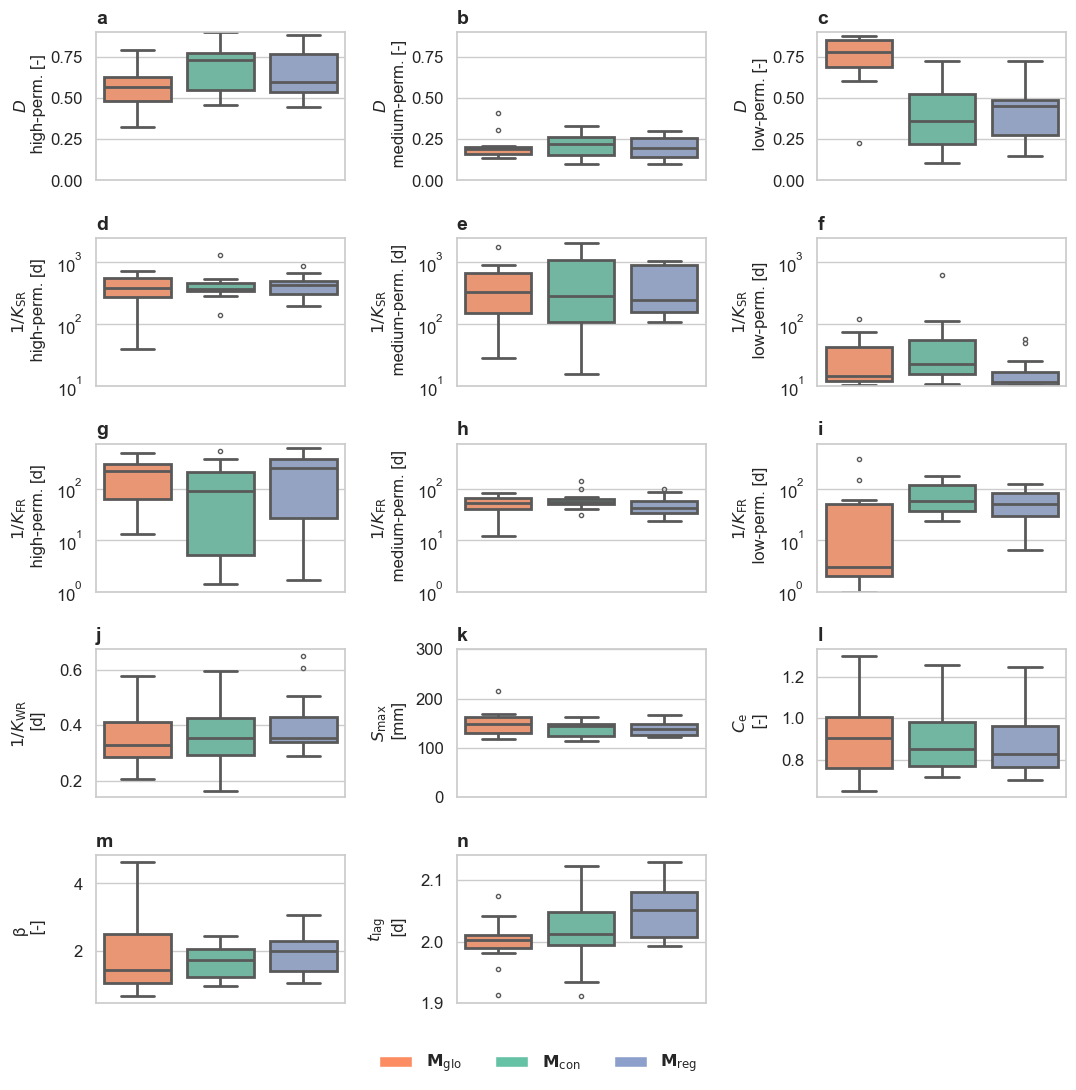

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


subplot_titles = list("abcdefghijklmnopqrstu")  # Enough for 26 variables


# Seaborn styling
sns.set_theme(style="whitegrid", font_scale=1.2)

# Prepare long-format data
def prepare_long_df(df, name):
    df_long = df.copy()
    df_long['source'] = name
    return df_long

regional_long = prepare_long_df(regional_params, 'Regional')
continental_long = prepare_long_df(continental_params, 'Continental')
global_long = prepare_long_df(global_params, 'Global')

all_long = pd.concat([global_long, continental_long, regional_long], axis=0)
all_long = all_long.melt(id_vars='source', var_name='variable', value_name='value')

# Colors for groups
palette = {
    'Regional': '#8da0cb',     # blue
    'Continental': '#66c2a5',  # green
    'Global': '#fc8d62'        # orange
}

# Variables to plot
variables = [

    'high_lowersplitter_splitpar', 
    'general_lowersplitter_splitpar',
    'low_lowersplitter_splitpar',

    'high_slow_k',
    'general_slow_k',
    'low_slow_k',
    
    'high_fast_k', 
    'general_fast_k',
    'low_fast_k',

    'high_snow_k', 
    'high_unsaturated_Smax', 
    'high_unsaturated_Ce',
    'high_unsaturated_beta', 
    'high_lag-fun_lag-time',
    ]


# Pretty labels for y-axes
pretty_labels = {

    'general_lowersplitter_splitpar': r'$\mathit{D}$' + '\n medium-perm. [-]',
    'high_lowersplitter_splitpar': r'$\mathit{D}$' + '\n high-perm. [-]',#
    'low_lowersplitter_splitpar': r'$\mathit{D}$' + '\n low-perm. [-]',#
    'high_fast_k': r'$1/\mathit{K}_{\mathrm{FR}}$' + '\n high-perm. [d]',
    'high_slow_k': r'$1/\mathit{K}_{\mathrm{SR}}$' + '\n high-perm. [d]',#
    'general_slow_k': r'$1/\mathit{K}_{\mathrm{SR}}$' + '\n medium-perm. [d]',#
    'general_fast_k': r'$1/\mathit{K}_{\mathrm{FR}}$' + '\n medium-perm. [d]',#
    'low_slow_k': r'$1/\mathit{K}_{\mathrm{SR}}$' + '\n low-perm. [d]',#
    'low_fast_k': r'$1/\mathit{K}_{\mathrm{FR}}$' + '\n low-perm. [d]',#

    'high_snow_k': r'$1/\mathit{K}_{\mathrm{WR}}$' + '\n [d]',#
    'high_unsaturated_Smax': r'$\mathit{S}_{\mathrm{max}}$' + '\n [mm]',
    'high_unsaturated_Ce': r'$\mathit{C}_{\mathrm{e}}$' + '\n [-]',#
    'high_unsaturated_beta': 'β \n [-]',#
    'high_lag-fun_lag-time': r'$\mathit{t}_{\mathrm{lag}}$' + '\n [d]',#


}

# Layout
ncols = 3
nrows = int(np.ceil(len(variables) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 11), sharey=False)
axes = axes.flatten()

# Plot
for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(
        data=all_long[all_long['variable'] == var],
        x='source', y='value',
        palette=palette,
        linewidth=2.0,
        fliersize=3,
        ax=ax
    )
    ax.set_title(subplot_titles[i], fontsize=14, weight='bold', loc="left")  # "A", "B", ...
    ax.set_xlabel('')
    ax.set_ylabel(pretty_labels.get(var, var), fontsize=12)
    ax.set_xticks([])  # remove x-axis group labels
    ax.tick_params(labelsize=12)

# Hide unused axes
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Custom legend
legend_elements = [
    Patch(facecolor=palette['Global'], label=r"$\mathbf{M_{\mathrm{glo}}}$"),
    Patch(facecolor=palette['Continental'], label=r"$\mathbf{M_{\mathrm{con}}}$"),
    Patch(facecolor=palette["Regional"], label=r"$\mathbf{M_{\mathrm{reg}}}$"),
]

axes[0].set_ylim(0, 0.9)  
axes[1].set_ylim(0, 0.9)  
axes[2].set_ylim(0, 0.9)  

axes[3].set_ylim(10, 2500)  
axes[4].set_ylim(10, 2500)  
axes[5].set_ylim(10, 2500)

axes[6].set_ylim(1, 750)  
axes[7].set_ylim(1, 750)  
axes[8].set_ylim(1, 750)  
axes[10].set_ylim(0, 300)  


axes[3].set_yscale('log')
axes[4].set_yscale('log')
axes[5].set_yscale('log')

axes[6].set_yscale('log')
axes[7].set_yscale('log')
axes[8].set_yscale('log')

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=12,
    frameon=False
)

# Align all y-axis labels
for ax in axes:
    ax.yaxis.set_label_coords(-0.2, 0.5)  # adjust -0.15 as needed

#axes[8].set_ylim(-10, 200)
plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.savefig("../results/figs/boxplots_params2.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

### Supporting information

#### Figure S1

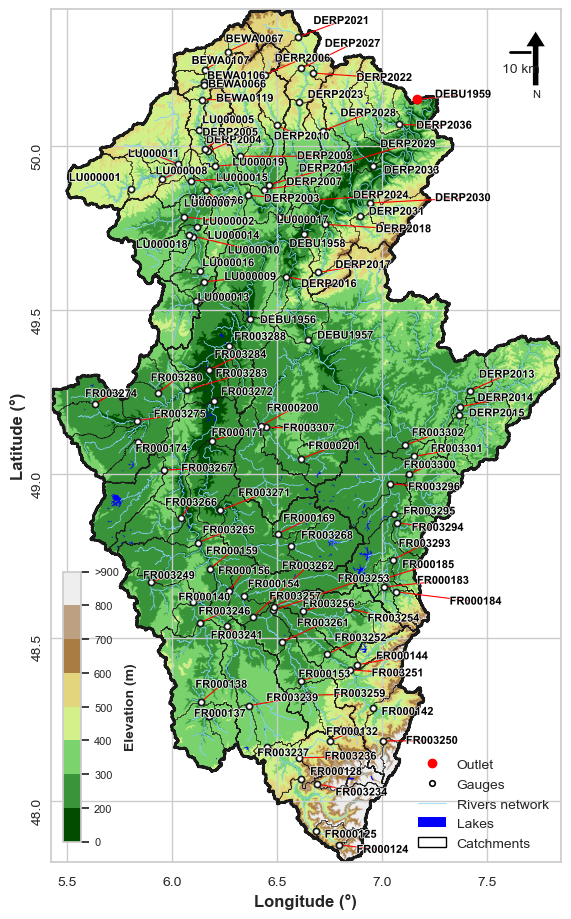

In [415]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import adjustText
from adjustText import adjust_text
# Define custom terrain colormap without blue
terrain_no_blue_colors = [
    (0.0,  "#004d00"),  # dark green
    (0.25, "#66cc66"),  # light green
    (0.5,  "#ffff99"),  # yellow
    (0.75, "#996633"),  # brown
    (1.0,  "#eeeeee")   # light gray/white
]

terrain_no_blue = LinearSegmentedColormap.from_list("terrain_no_blue", terrain_no_blue_colors)



# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, ax = plt.subplots(figsize=(9, 9))


data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 12           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('white')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

#world.plot(ax=ax, color='none', edgecolor='red', linewidth=1, alpha=0.25)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color classes (discrete intervals)
bounds = [0, 200, 300, 400, 500, 600, 700, 800, 900]  # Define class boundaries
cmap = plt.get_cmap(terrain_no_blue)  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.23, 0.075, 0.02, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)

tick_labels = [str(b) for b in bounds[:-1]] + ['>900']
cbar.ax.set_yticklabels(tick_labels)

cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=10)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
#cbar.ax.set_aspect('auto')

# Set the title and show the plot
#ax.set_title('C', loc = "left", fontsize=14, fontweight="bold")

# Plot the river
rivers_moselle.plot(ax=ax, linewidth=0.5, color="lightskyblue")

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax, facecolor='none', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2, label='Sub-catchments')
catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5, label='Sub-catchments')
lakes.plot(ax=ax, facecolor='blue', edgecolor='none', linewidth=1, label='Lakes and reservoirs')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax, color='black', markersize=30, edgecolor='none', linewidth=0.5, 
#                          label='Streamflow gauges', zorder=1000)

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='white', markersize=20, edgecolor='k', linewidth=1.25, 
                          label='Streamflow gauges', zorder=1000)

# Plot the points from network_estreams_filtered
network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax, color='red', markersize=50, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.25, x_max+0.2)
ax.set_ylim(y_min-0.2, y_max+0.2)


ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=12)

# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Catchments')

#countries_patch = Patch(facecolor='none', edgecolor='red', lw=0.25, alpha = 0.5, label='Countries')

# For streamflow gauges (as black dots)
#streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=4, label='Gauges')
streamflow_marker = Line2D(
    [0], [0],
    color='none',                # No line connecting markers
    marker='o',                  # Circle marker
    markersize=4,                # Size in points
    markerfacecolor='white',     # Fill color inside the circle
    markeredgecolor='black',     # Color of the circle's edge
    markeredgewidth=1.2,         # Width of the edge
    label='Gauges'
)

# For outlet gauges (as black dots)
outlet_marker = Line2D([0], [0], color='red', lw=0, marker='o', markersize=6, label='Outlet')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers network')

## Add the legend with all items
#legend = ax.legend(handles=[outlet_marker, streamflow_marker, river_line, subcatchment_patch, countries_patch], 
#                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.95, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=10)

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)

# Add labels for selected basin_ids
label_df = network_estreams_gdf.index.tolist()

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

import matplotlib.patheffects as pe

texts = []
points_x, points_y = [], []  # store the reference points

for basin in label_df:
    x = network_estreams_gdf.loc[basin, 'lon']
    y = network_estreams_gdf.loc[basin, 'lat']
    t = ax.text(
        x, y, basin,
        fontsize=8, ha='left', va='bottom',
        color='black', zorder=20000, fontweight="bold"
    )
    # Add white outline
    t.set_path_effects([
        pe.withStroke(linewidth=1, foreground="white")
    ])
    texts.append(t)
    points_x.append(x)
    points_y.append(y)

# Adjust with leader lines
adjust_text(
    texts, 
    x=points_x, y=points_y,  # anchor texts to their points
    ax=ax,
    expand_text=(0.1, 0.1),
    arrowprops=dict(arrowstyle="-", color="red", lw=0.8, zorder=19999))

import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax.set_aspect('equal')
ax.grid(True)


# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', linewidth=1, label='Catchments')
lakes_patch = Patch(facecolor='blue', edgecolor='none', linewidth=1, label='Lakes')


# For streamflow gauges (as black dots)
streamflow_marker = Line2D(
    [0], [0],
    color='none',                # No line connecting markers
    marker='o',                  # Circle marker
    markersize=4,                # Size in points
    markerfacecolor='white',     # Fill color inside the circle
    markeredgecolor='black',     # Color of the circle's edge
    markeredgewidth=1.2,         # Width of the edge
    label='Gauges'
)

# For outlet gauges (as black dots)
outlet_marker = Line2D([0], [0], color='red', lw=0, marker='o', markersize=6, label='Outlet')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers network', color='lightskyblue')

# Add the legend with all items
legend = ax.legend(handles=[outlet_marker, streamflow_marker, river_line, lakes_patch, subcatchment_patch], 
                   loc='lower right', fontsize=10, title="", title_fontsize='8', frameon=False)



# Adjust the layout to remove extra space
plt.tight_layout(pad=0)

# Save including everything (colorbar + legend)
plt.savefig(
    r"/Users/nascimth/Library/CloudStorage/OneDrive-Eawag/Eawag/Papers/Moselle_superflexpy/GitHub/estreams_superflexpy/results/figs/appendix_study)area.png",
    dpi=300,
    bbox_inches='tight'
)

# Show the plot
plt.show()

#### Correlations

In [86]:
estreams_attributes_clipped_filters["nse_r1comp"] = data_diff_val_complete["nse_r1comp"]
estreams_attributes_clipped_filters["nse_c1comp"] = data_diff_val_complete["nse_c1comp"]
estreams_attributes_clipped_filters["nse_g1comp"] = data_diff_val_complete["nse_g1comp"]
estreams_attributes_clipped_filters["nse_nogeo"] = data_diff_val_complete["nse_nogeo"]
estreams_attributes_clipped_filters["bfi_obs"] = data_diff_val_complete["bfi_obs"]

estreams_attributes_clipped_filters_plot = estreams_attributes_clipped_filters.copy()
estreams_attributes_clipped_filters_plot.drop("group", inplace=True, axis=1)
estreams_attributes_clipped_filters_plot_nodup = estreams_attributes_clipped_filters_plot[~estreams_attributes_clipped_filters_plot.index.duplicated(keep='first')]
estreams_attributes_clipped_filters_plot_nodup["lakes_area_frac"] = estreams_attributes_clipped_filters_plot_nodup["lakes_tot_area"] / estreams_attributes_clipped_filters_plot_nodup["area_estreams"]
estreams_attributes_clipped_filters_plot_nodup["lakes_vol_frac"] = estreams_attributes_clipped_filters_plot_nodup["lakes_tot_vol"] / estreams_attributes_clipped_filters_plot_nodup["area_estreams"]

corr_series = estreams_attributes_clipped_filters_plot.iloc[:, 30:].corr(method="pearson")["nse_r1comp"]
filtered_corr = corr_series[abs(corr_series) > 0.0]

filtered_corr[20:40]

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/3934226551.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estreams_attributes_clipped_filters_plot_nodup["lakes_area_frac"] = estreams_attributes_clipped_filters_plot_nodup["lakes_tot_area"] / estreams_attributes_clipped_filters_plot_nodup["area_estreams"]
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/3934226551.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estreams_attributes_clipped_filters_plot_nodup["lakes_v

hp_time              0.165274
lp_freq             -0.133100
lp_dur              -0.058889
lp_time              0.017367
ele_mt_max           0.085766
ele_mt_mean         -0.062911
ele_mt_min          -0.213930
slp_dg_mean         -0.327416
flat_area_fra        0.106113
steep_area_fra      -0.391404
elon_ratio           0.106516
strm_dens            0.086838
lit_dom             -0.094143
bedrk_dep            0.242876
perm_verylow_glob   -0.074466
perm_low_glob        0.220460
perm_medium_glob     0.123555
perm_high_glob      -0.160111
lit_fra_su           0.215180
lit_fra_ss          -0.186315
Name: nse_r1comp, dtype: float64

In [87]:
corr_series = estreams_attributes_clipped_filters_plot.iloc[:, 30:].corr(method="pearson")["nse_g1comp"]
filtered_corr = corr_series[abs(corr_series) > 0.2]

filtered_corr

baseflow_index          -0.343992
hfd_mean                -0.545481
hfd_std                 -0.371417
q_5                     -0.296343
ele_mt_min              -0.266157
slp_dg_mean             -0.334079
flat_area_fra            0.207581
steep_area_fra          -0.350439
lit_dom                 -0.248861
bedrk_dep                0.290017
perm_low_glob            0.244927
perm_medium_glob         0.309231
perm_high_glob          -0.422997
lit_fra_su               0.251958
lit_fra_ss              -0.453646
lit_fra_sc               0.214089
lit_fra_mt               0.244927
lit_fra_va              -0.571087
perm_high_cont          -0.325242
lit_fra_Gravels          0.266144
lit_fra_Sandstones      -0.371259
root_dep_mean            0.329026
root_dep_max             0.246618
soil_tawc_mean           0.221433
soil_fra_sand_mean      -0.320538
soil_fra_silt_mean       0.242124
soil_fra_clay_mean       0.290644
soil_fra_grav_mean       0.358654
soil_bd_mean            -0.357769
lai_mean      

In [88]:
data_diff_val_complete.min() 

nse_nogeo       -0.506631
nse_g1comp       0.165087
nse_c1comp       0.095085
nse_r1comp       0.181581
bfi_obs          0.420919
bfi_r1comp       0.498500
bfi_c1comp       0.523026
bfi_g1comp       0.508287
bfi_nogeo        0.588289
hfd_obs         97.277778
hfd_r1comp      97.388889
hfd_c1comp      98.777778
hfd_g1comp      96.166667
hfd_nogeo       93.722222
slope_obs        0.958338
slope_r1comp     1.232520
slope_c1comp     1.142526
slope_g1comp     1.279501
slope_nogeo      1.798806
qmean_obs        0.518305
qmean_r1comp     0.578160
qmean_c1comp     0.581992
qmean_g1comp     0.586953
qmean_nogeo      0.578906
dtype: float64

In [89]:

corr_series = estreams_attributes_clipped_filters_plot_nodup.iloc[:, 30:].corr(method="pearson")["lakes_vol_frac"]
filtered_corr = corr_series[abs(corr_series) > 0.0]
filtered_corr[-10:]

perm_high_glob2      0.146316
perm_medium_glob2   -0.131991
perm_low_glob2      -0.007677
nse_r1comp          -0.298286
nse_c1comp          -0.359153
nse_g1comp          -0.339669
nse_nogeo           -0.375259
bfi_obs              0.153948
lakes_area_frac      0.727570
lakes_vol_frac       1.000000
Name: lakes_vol_frac, dtype: float64

In [90]:
estreams_attributes_clipped_filters_plot_nodup.columns[40:]

Index(['hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perm_verylow_glob',
       'perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 'lit_fra_su',
       'lit_fra_ss', 'lit_fra_sm', 'lit_fra_sc', 'lit_fra_mt', 'lit_fra_pi',
       'lit_fra_py', 'lit_fra_vi', 'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa',
       'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb', 'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont',
       'lit_fra_Conglomerates', 'lit_fra_Conglomerates and sands',
       'lit_fra_Gravels', 'lit_fra_Sands', 'lit_fra_Sandstones',
       'lit_fra_Sandstones and sands', 'root_dep_mean', 'root_dep_max',
       'root_dep_min', 'soil_tawc_mean', 'soil_fra_sand_mean'

In [101]:
corr_series = estreams_attributes_clipped_filters_plot_nodup.iloc[:, 30:].corr(method="spearman")["hfd_mean"]
corr_series.iloc[-20
                 :]

lakes_num              0.073267
lakes_tot_area         0.066557
lakes_tot_vol          0.056840
sno_cov_mean          -0.046515
irri_1990             -0.150949
irri_2005             -0.184487
stations_num_p_mean   -0.151855
perm_high_regi         0.643059
perm_medium_regi      -0.000728
perm_low_regi         -0.308139
perm_high_glob2        0.221761
perm_medium_glob2     -0.211071
perm_low_glob2         0.323503
nse_r1comp            -0.317834
nse_c1comp            -0.327547
nse_g1comp            -0.082907
nse_nogeo             -0.110163
bfi_obs                0.828624
lakes_area_frac        0.036171
lakes_vol_frac         0.040239
Name: hfd_mean, dtype: float64

In [107]:
estreams_attributes_clipped_filters_plot_nodup["area"] = estreams_attributes_clipped_filters_plot_nodup["area_estreams"]
corr_series = estreams_attributes_clipped_filters_plot_nodup.iloc[:, 30:].corr(method="spearman")["nse_r1comp"]
corr_series.iloc[-10:
                 :]

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_65216/1697488289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estreams_attributes_clipped_filters_plot_nodup["area"] = estreams_attributes_clipped_filters_plot_nodup["area_estreams"]


perm_medium_glob2   -0.194363
perm_low_glob2       0.241368
nse_r1comp           1.000000
nse_c1comp           0.969495
nse_g1comp           0.746873
nse_nogeo            0.890108
bfi_obs             -0.146684
lakes_area_frac      0.129895
lakes_vol_frac       0.193008
area                 0.544676
Name: nse_r1comp, dtype: float64

In [329]:
estreams_attributes_clipped_filters_plot_nodup["lakes_area_frac"] = estreams_attributes_clipped_filters_plot_nodup["lakes_tot_area"] / estreams_attributes_clipped_filters_plot_nodup["area_estreams"]
estreams_attributes_clipped_filters_plot_nodup["lakes_vol_frac"] = estreams_attributes_clipped_filters_plot_nodup["lakes_tot_vol"] / estreams_attributes_clipped_filters_plot_nodup["area_estreams"]

estreams_attributes_clipped_filters_plot_nodup["lakes_mean_depth"] = estreams_attributes_clipped_filters_plot_nodup["lakes_tot_vol"] / estreams_attributes_clipped_filters_plot_nodup["lakes_tot_area"]



In [330]:
estreams_attributes_clipped_filters_plot_nodup

Unnamed: 0    gauge_id            gauge_name gauge_country  \
basin_id                                                               
LU000018           0           5            Schoenfels            LU   
LU000010           1           6             Hunnebuer            LU   
LU000001           2          17            Bigonville            LU   
DERP2028           3  2674030900          Eisenschmitt            DE   
FR000183           4  A900105050              A9001050            FR   
...              ...         ...                   ...           ...   
DERP2007         106  2628050400           Pruemzurlay            DE   
FR003271         107  A782101001   La Seille Ã  Nomeny            FR   
FR003301         108  A930108040  La Sarre Ã  Wittring            FR   
DERP2003         109  2620050500            Bollendorf            DE   
DEBU1958         110    26500100    BundespegelTrierUp            DE   

          gauge_provider                                river  lon_snap  \
basin_id                                                                  
LU000018  LU_CONTACTFORM                                Mamer  6.100795   
LU000010  LU_CONTACTFORM                                Eisch  6.079524   
LU000001  LU_CONTACTFORM                                 Sure  5.801399   
DERP2028           DE_RP                                 Salm  6.718000   
FR000183    FR_EAUFRANCE  La Sarre à Laneuveville-lès-Lorquin  7.008689   
...                  ...                                  ...       ...   
DERP2007           DE_RP                                Pruem  6.437000   
FR003271    FR_EAUFRANCE                   La Seille à Nomeny  6.227788   
FR003301    FR_EAUFRANCE                  La Sarre à Wittring  7.150066   
DERP2003           DE_RP                                Sauer  6.359000   
DEBU1958           DE_BU                                Mosel  6.627000   

           lat_snap       lon        lat  ...  perm_low_glob2  nse_r1comp  \
basin_id                                  ...                               
LU000018  49.723112  6.100795  49.723112  ...             0.0    0.661654   
LU000010  49.729184  6.079524  49.729184  ...             0.0    0.781961   
LU000001  49.869821  5.801399  49.869821  ...             0.0    0.875687   
DERP2028  50.048000  6.718000  50.048000  ...             1.0    0.706292   
FR000183  48.654579  7.008689  48.654579  ...             6.0    0.488465   
...             ...       ...        ...  ...             ...         ...   
DERP2007  49.868000  6.437000  49.868000  ...             0.0    0.834975   
FR003271  48.888271  6.227788  48.888271  ...             0.0    0.751781   
FR003301  49.053225  7.150066  49.053225  ...             0.0    0.861112   
DERP2003  49.851000  6.359000  49.851000  ...             0.0    0.889834   
DEBU1958  49.732000  6.627000  49.732000  ...             4.0    0.878013   

          nse_c1comp  nse_g1comp  nse_nogeo   bfi_obs lakes_area_frac  \
basin_id                                                                
LU000018    0.515473    0.656544   0.623167  0.552706        0.000000   
LU000010    0.689694    0.694558   0.736587  0.622472        0.000000   
LU000001    0.877058    0.631810   0.822228  0.549832        0.000000   
DERP2028    0.629006    0.748662   0.824758  0.592346        0.000000   
FR000183    0.468789    0.468859   0.381274  0.740801        0.000000   
...              ...         ...        ...       ...             ...   
DERP2007    0.819834    0.855475   0.798634  0.501588        0.000451   
FR003271    0.771728    0.753425   0.770787  0.545286        0.008363   
FR003301    0.850951    0.859052   0.838624  0.545102        0.010854   
DERP2003    0.887349    0.851932   0.874583  0.560047        0.000686   
DEBU1958    0.879916    0.873524   0.874194  0.610912        0.002841   

          marker_size  lakes_vol_frac  lakes_mean_depth  
basin_id                                                 
LU000018           10        

In [331]:
estreams_attributes_clipped_filters_plot_nodup[estreams_attributes_clipped_filters_plot_nodup.hfd_mean>150][["hfd_mean", "lakes_tot_area","lakes_num", "area_estreams", "lakes_area_frac", "lulc_2006_agriculture", "lakes_tot_vol", "lakes_vol_frac", "lakes_mean_depth", "nse_r1comp"]]

hfd_mean  lakes_tot_area  lakes_num  area_estreams  lakes_area_frac  \
basin_id                                                                        
FR000183   152.760            0.00        0.0         70.750         0.000000   
FR000144   172.085            2.86        2.0        117.784         0.024282   
FR000184   160.347            0.00        0.0         89.950         0.000000   
DERP2013   166.582            0.10        1.0        530.000         0.000189   
FR003250   156.082            0.00        0.0         67.143         0.000000   
DERP2014   151.561            0.28        1.0        430.000         0.000651   

          lulc_2006_agriculture  lakes_tot_vol  lakes_vol_frac  \
basin_id                                                         
FR000183                  0.151           0.00        0.000000   
FR000144                  0.032          57.45        0.487757   
FR000184                  0.042           0.00        0.000000   
DERP2013                  0.311           0.62        0.001170   
FR003250                  0.164           0.00        0.000000   
DERP2014                  0.482           1.42        0.003302   

          lakes_mean_depth  nse_r1comp  
basin_id                                
FR000183               NaN    0.488465  
FR000144         20.087413    0.235977  
FR000184               NaN    0.636002  
DERP2013          6.200000    0.443957  
FR003250               NaN    0.181581  
DERP2014          5.071429    0.803130

In [327]:
0.4877/10**6

4.877e-07

In [332]:
estreams_attributes_clipped_filters_plot_nodup.lakes_mean_depth.describe()

count    61.000000
mean      8.097114
std       8.398328
min       1.500000
25%       3.261905
50%       5.196457
75%       7.653846
max      37.575758
Name: lakes_mean_depth, dtype: float64

In [319]:
estreams_attributes_clipped_filters_plot_nodup.lakes_tot_vol.describe()

count    108.000000
mean      27.434259
std       64.801459
min        0.000000
25%        0.000000
50%        0.725000
75%       34.697500
max      396.310000
Name: lakes_tot_vol, dtype: float64

In [317]:
estreams_attributes_clipped_filters_plot_nodup.lakes_vol_frac.describe()

count    108.000000
mean       0.018140
std        0.052393
min        0.000000
25%        0.000000
50%        0.001934
75%        0.016164
max        0.487757
Name: lakes_vol_frac, dtype: float64

In [103]:
estreams_attributes_clipped_filters_plot_nodup[estreams_attributes_clipped_filters_plot_nodup.nse_r1comp<0.5][["hfd_mean", "lakes_tot_area","lakes_num", "area_estreams", "lakes_area_frac", "lulc_2006_agriculture", "lakes_tot_vol", "lakes_vol_frac", "nse_r1comp"]]

hfd_mean  lakes_tot_area  lakes_num  area_estreams  lakes_area_frac  \
basin_id                                                                        
FR000183   152.760            0.00        0.0         70.750         0.000000   
FR000185   145.097            0.00        0.0        188.492         0.000000   
FR000144   172.085            2.86        2.0        117.784         0.024282   
FR003280   148.667            0.00        0.0         74.738         0.000000   
DERP2013   166.582            0.10        1.0        530.000         0.000189   
FR003259   136.647            0.00        0.0         64.746         0.000000   
FR003250   156.082            0.00        0.0         67.143         0.000000   

          lulc_2006_agriculture  lakes_tot_vol  lakes_vol_frac  nse_r1comp  
basin_id                                                                    
FR000183                  0.151           0.00        0.000000    0.488465  
FR000185                  0.156           0.00        0.000000    0.263676  
FR000144                  0.032          57.45        0.487757    0.235977  
FR003280                  0.749           0.00        0.000000    0.402323  
DERP2013                  0.311           0.62        0.001170    0.443957  
FR003259                  0.414           0.00        0.000000    0.272996  
FR003250                  0.164           0.00        0.000000    0.181581

<Axes: >

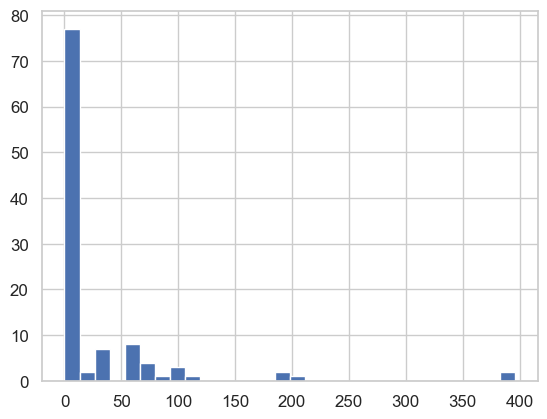

In [320]:
estreams_attributes_clipped_filters_plot_nodup.lakes_tot_vol.hist(bins=30)

<Axes: >

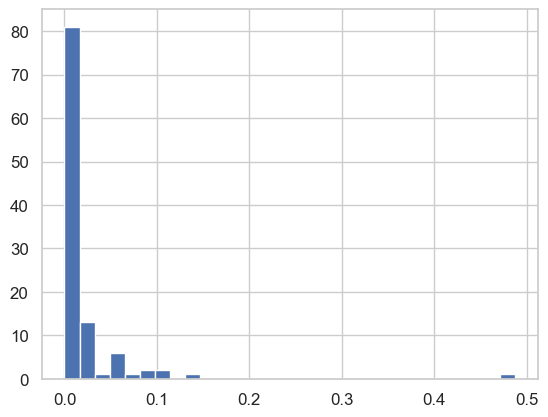

In [311]:
estreams_attributes_clipped_filters_plot_nodup.lakes_vol_frac.hist(bins=30)

<Axes: >

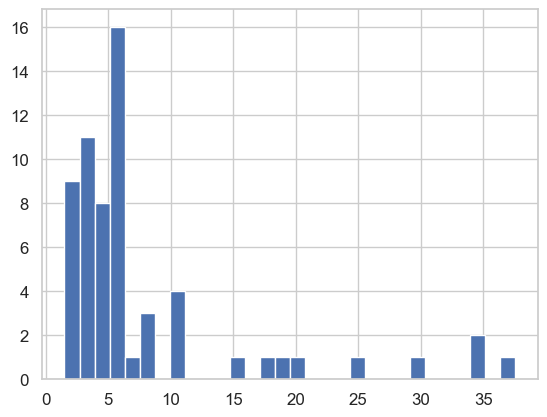

In [333]:
estreams_attributes_clipped_filters_plot_nodup.lakes_mean_depth.hist(bins=30)

#### Figure S3

In [383]:
estreams_attributes_clipped_filters_plot_nodup["lakes_vol_frac_in_mm"] = estreams_attributes_clipped_filters_plot_nodup["lakes_vol_frac"] * 1000

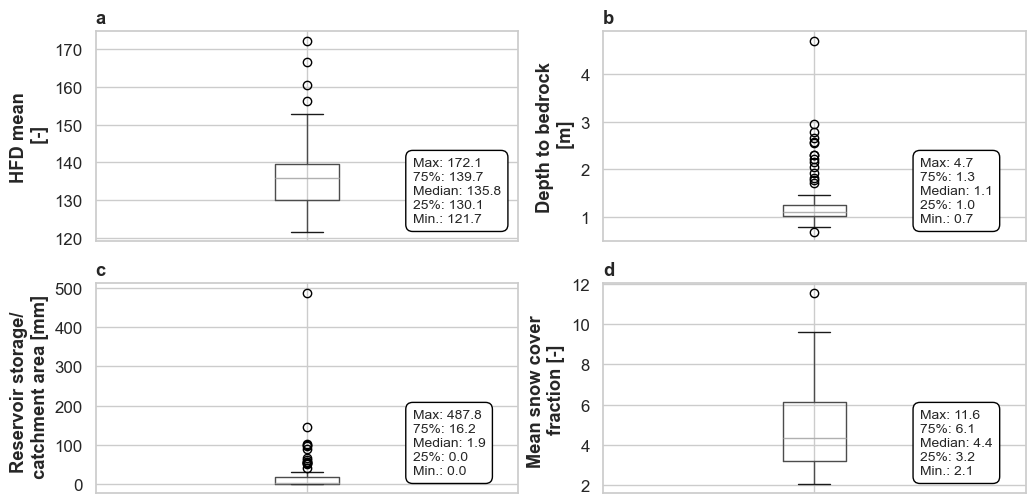

In [398]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()  # convert 2x2 array into 1D list of axes

panels = [
    ("hfd_mean", "HFD mean\n [-]", "a"),
    ("bedrk_dep", "Depth to bedrock\n [m]", "b"),
    ("lakes_vol_frac_in_mm", "Reservoir storage/ \n catchment area [mm]", "c"),
    ("sno_cov_mean", "Mean snow cover \nfraction [-]", "d")
]

# Loop through the panels
for i, (x_col, xlabel, label) in enumerate(panels):
    ax = axes[i]



    # draw the boxplot
    estreams_attributes_clipped_filters_plot_nodup.boxplot(column=x_col, ax=ax)
    ax.set_ylabel(xlabel)
    ax.set_xticklabels([])

    ax.set_title(label, loc="left", fontweight="bold")

    # compute stats
    vals = estreams_attributes_clipped_filters_plot_nodup[x_col].dropna()
    q25 = vals.quantile(0.25)
    median = vals.median()
    q75 = vals.quantile(0.75)
    vmax = vals.max()
    vmin = vals.min()

    # prepare text
    stats_text = (
        f"Max: {vmax:.1f}\n"
        f"75%: {q75:.1f}\n"
        f"Median: {median:.1f}\n"
        f"25%: {q25:.1f}\n"
        f"Min.: {vmin:.1f}"
    )

    # add a single text box at 90% x, 90% y (axes coords)
    ax.text(
        0.75, 0.4, stats_text,
        transform=ax.transAxes,        # <-- use axes fraction coordinates
        fontsize=10,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5")
    )

# Save figure
plt.savefig(
    "../results/figs/boxplot_figures3.png",
    dpi=300,
    bbox_inches='tight'

    
)
plt.show()


In [399]:
estreams_attributes_clipped_filters_plot_nodup.root_dep_mean.describe()

count    108.000000
mean     104.802389
std       17.581981
min       67.233000
25%       92.945500
50%      110.495000
75%      117.545500
max      130.000000
Name: root_dep_mean, dtype: float64

In [400]:
estreams_attributes_clipped_filters_plot_nodup.bedrk_dep.describe()

count    108.000000
mean       1.283593
std        0.548733
min        0.691000
25%        1.030000
50%        1.112500
75%        1.252000
max        4.694000
Name: bedrk_dep, dtype: float64

#### Figure S4

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_83009/1076636666.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estreams_attributes_clipped_filters_plot_nodup["marker_size"] = estreams_attributes_clipped_filters_plot_nodup["area_estreams"].apply(get_marker_size)


nse_g1comp
nse_r1comp
nse_g1comp
nse_r1comp


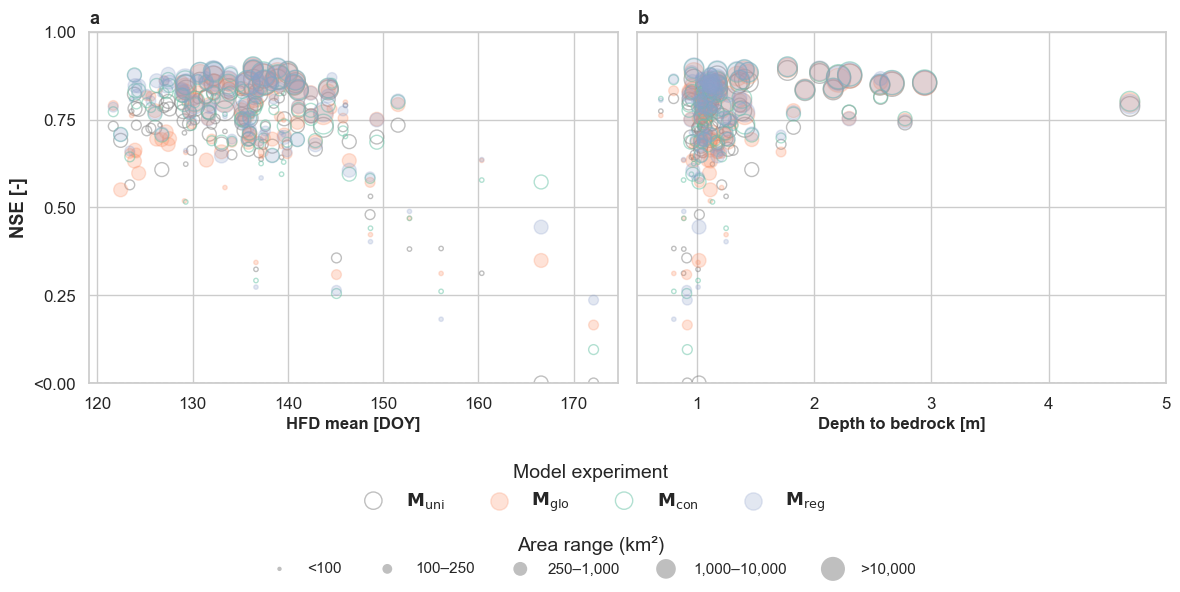

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.1)

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Define the two variables to plot
panels = [
    ("hfd_mean", "HFD mean [DOY]", "a"),
    ("bedrk_dep", "Depth to bedrock [m]", "b"),
]

# Define NSE columns and colors
nse_columns = {
    "nse_nogeo": "gray",
    "nse_g1comp": "#fc8d62",
    "nse_c1comp": "#66c2a5",
    "nse_r1comp": "#8da0cb",
}

# Function to determine marker size
def get_marker_size(area):
    if area < 100:
        return 10
    elif 100 <= area < 250:
        return 50
    elif 250 <= area < 1000:
        return 100
    elif 1000 <= area < 10000:
        return 200
    else:
        return 300

# Pre-compute marker sizes based on catchment area
estreams_attributes_clipped_filters_plot_nodup["marker_size"] = estreams_attributes_clipped_filters_plot_nodup["area_estreams"].apply(get_marker_size)

# Loop through the panels
for i, (x_col, xlabel, label) in enumerate(panels):
    ax = axes[i]

    for nse_col, color in nse_columns.items():


        if nse_col == "nse_nogeo":
            x = estreams_attributes_clipped_filters_plot_nodup[x_col]
            y = estreams_attributes_clipped_filters_plot_nodup[nse_col].clip(lower=0, upper=1)
            sizes = estreams_attributes_clipped_filters_plot_nodup["marker_size"]
            ax.scatter(x, y, color="none", label=nse_col if i == 0 else "", alpha=0.5, s=sizes, edgecolors=color)
        elif nse_col == "nse_c1comp":
            x = estreams_attributes_clipped_filters_plot_nodup[x_col]
            y = estreams_attributes_clipped_filters_plot_nodup[nse_col].clip(lower=0, upper=1)
            sizes = estreams_attributes_clipped_filters_plot_nodup["marker_size"]
            ax.scatter(x, y, color="none", label=nse_col if i == 0 else "", alpha=0.5, s=sizes, edgecolors=color)
        else:
            print(nse_col)
            x = estreams_attributes_clipped_filters_plot_nodup[x_col]
            y = estreams_attributes_clipped_filters_plot_nodup[nse_col].clip(lower=0, upper=1)
            sizes = estreams_attributes_clipped_filters_plot_nodup["marker_size"]
            ax.scatter(x, y, color=color, label=nse_col if i == 0 else "", alpha=0.25, s=sizes)


    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("NSE [-]" if i == 0 else "")
    ax.set_title(label, loc='left', fontsize=13, fontweight="bold")
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["<0.00", "0.25", "0.50", "0.75", "1.00"])
    ax.set_ylim(0, 1)

# First legend: NSE model experiment
handles_model, _ = axes[0].get_legend_handles_labels()
fig.legend(
    handles_model,
    [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", r"$\mathbf{M_{\mathrm{reg}}}$"],
    title="Model experiment",
    loc='lower center',
    ncol=4,
    fontsize=13,
    title_fontsize=14,
    frameon=False,
    bbox_to_anchor=(0.5, 0.1)  # slightly below plot
)

# Second legend: Marker size (area)
size_handles = [
    plt.scatter([], [], s=10,  color="gray", alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=50,   color="gray",alpha=0.5, label='100–250', edgecolors='none'),
    plt.scatter([], [], s=100,   color="gray",alpha=0.5, label='250–1,000', edgecolors='none'),
    plt.scatter([], [], s=200,   color="gray",alpha=0.5, label='1,000–10,000', edgecolors='none'),
    plt.scatter([], [], s=300,  color="gray",alpha=0.5, label='>10,000', edgecolors='none')
]

fig.legend(
    handles=size_handles,
    title='Area range (km²)',
    loc='lower center',
    ncol=5,
    bbox_to_anchor=(0.5, 0),  # lower than the model legend
    frameon=False,
    fontsize=11,
    title_fontsize=14
)
#axes[0].set_xscale("log")
#axes[1].set_xscale("log")

axes[0].xaxis.set_major_formatter(mticker.ScalarFormatter())
axes[0].xaxis.set_minor_formatter(mticker.ScalarFormatter())  # hide minor tick labels if cluttered



ticks = [1, 2, 3, 4, 5]
axes[1].set_xticks(ticks)
axes[1].set_xticklabels([str(t) for t in ticks])  # show as plain numbers

#axes[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
#axes[1].xaxis.set_minor_formatter(mticker.ScalarFormatter())  # hide minor tick labels if cluttered




# Adjust layout to reserve enough space for both legends
plt.tight_layout(rect=[0, 0.23, 1, 1])  # leave more space at the bottom

# Save figure
plt.savefig(
    "../results/figs/correlations_hfd_bedrockarea_scaled.png",
    dpi=300,
    bbox_inches='tight'

    
)

plt.show()


#### Supporting Tables (CSVs)

In [339]:
estreams_attributes_clipped_filters_plot_nodup_appendix = estreams_attributes_clipped_filters_plot_nodup.copy()

estreams_attributes_clipped_filters_plot_nodup_appendix["perm_high_cont2"] = estreams_attributes_clipped_filters_plot_nodup_appendix["perm_high_cont"] 
estreams_attributes_clipped_filters_plot_nodup_appendix["perm_medium_cont2"] = estreams_attributes_clipped_filters_plot_nodup_appendix["perm_medium_cont"] + estreams_attributes_clipped_filters_plot_nodup_appendix["perm_low_cont"]
estreams_attributes_clipped_filters_plot_nodup_appendix["perm_low_cont2"] = estreams_attributes_clipped_filters_plot_nodup_appendix["perm_verylow_cont"] 

estreams_attributes_clipped_filters_plot_nodup_appendix = estreams_attributes_clipped_filters_plot_nodup_appendix[['gauge_id', 
                                                                                                                  'gauge_name',
                                                                                                                  'gauge_country',
       'gauge_provider', 'river', 'lon_snap', 'lat_snap', 'area_official', 'area_estreams', 'area_flag', 'area_rel',
       'start_date', 'end_date', 'num_years', 'gauges_upstream', 'q_mean', 'q_runoff_ratio',
       'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index',
       'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time', 'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max',
       'ele_mt_mean', 'ele_mt_min', 'slp_dg_mean', 'flat_area_fra',
       'steep_area_fra', 'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',
        'lit_fra_su','lit_fra_ss', 'lit_fra_sm', 'lit_fra_sc', 'lit_fra_mt', 'lit_fra_pi',
       'lit_fra_py', 'lit_fra_vi', 'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa',
       'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb', 

       'perm_high_regi', 'perm_medium_regi', 'perm_low_regi', 
       'perm_high_cont2', 'perm_medium_cont2', 'perm_low_cont2', 
       'perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',
       
       'root_dep_mean', 'root_dep_max',
       'root_dep_min', 'soil_tawc_mean', 'soil_fra_sand_mean',
       'soil_fra_silt_mean', 'soil_fra_clay_mean', 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
       
       'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'lakes_tot_area', 'lakes_tot_vol', 'sno_cov_mean', 'irri_1990',
       'irri_2005', 'stations_num_p_mean',  'nse_r1comp', 'nse_c1comp',
       'nse_g1comp', 'nse_nogeo']]

In [361]:
estreams_attributes_clipped_filters_plot_nodup_appendix.to_csv("../results/supporting_information/moselle_attributes.csv", index=True)

In [114]:
data_diff_val_complete_dict_plot[["lat", "lon"]] = estreams_attributes_clipped_filters_plot_nodup[["lat_snap", "lon_snap"]]
data_diff_cal_complete_dict_plot[["lat", "lon"]] = estreams_attributes_clipped_filters_plot_nodup[["lat_snap", "lon_snap"]]    
data_diff_calibration_complete[["lat", "lon"]] = estreams_attributes_clipped_filters_plot_nodup[["lat_snap", "lon_snap"]]    


data_diff_val_complete_dict_plot.to_csv("../results/supporting_information/space_time_eval_median_nse_signatures.csv", index=True)
data_diff_cal_complete_dict_plot.to_csv("../results/supporting_information/space_eval_median_nse_signatures.csv", index=True)
data_diff_calibration_complete.to_csv("../results/supporting_information/calibration_median_nse_signatures.csv", index=True)


In [362]:
estreams_attributes_clipped_filters_plot_nodup_appendix.iloc[:, 15:].corr(method='pearson').to_csv("../results/supporting_information/moselle_attributes_correlation_pearson.csv", index=True)
estreams_attributes_clipped_filters_plot_nodup_appendix.iloc[:, 15:].corr(method='spearman').to_csv("../results/supporting_information/moselle_attributes_correlation_spearman.csv", index=True)

## Case for the three catchments with baseflow wrong

In [169]:
from pathlib import Path
import xarray as xr

# Base directory and group names
base_dir = Path("../results/sim/FR003250_FR000185_FR003259")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.mean(dim="group")

# Initialize dict to collect NSEs
nse_results = {}

# Define the time range
start_date = "1989-10-01"
end_date = "2015-09-30"

selected_gauge_ids = ["FR003250", "FR000185", "FR003259"]

# Clip by gauges and time
ds_mean_clipped = ds_mean.sel(
    gauge_id=selected_gauge_ids,
    date=slice(start_date, end_date)
)

# Loop over gauges and compute NSE within defined time period
for gauge_id in ds_mean_clipped.gauge_id.values:
    # Subset for gauge and time period
    ts = ds_mean_clipped.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    obs = ts["observation"].values

    nse_results[gauge_id] = {
        'nse_r1comp': compute_nse(obs, ts["regional"].values),
    }


# Convert to DataFrame
data_diff_val_FR003250_FR000185_FR003259_dict_plot = pd.DataFrame.from_dict(nse_results, orient='index')


# Sources to evaluate
sources = ['observation', 'regional']

MIN_VALID_POINTS = 365  # You can adjust this threshold if needed

def safe_bfi(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return baseflow_index(masked_sim, alpha=0.925, warmup=365, n_passes=3)[0]

def safe_hfd(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return hfd_mean(masked_sim, datetime_coord="date")

def safe_slope(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return slope_fdc(masked_sim)

def safe_qmean(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return q_mean(masked_sim)

signature_funcs = {
    'bfi': safe_bfi,
    'hfd': safe_hfd,
    'slope': safe_slope,
    'qmean': safe_qmean,
}

# Initialize storage
signature_results = []

# Loop over gauges
for gauge in tqdm.tqdm(ds_mean_clipped.gauge_id.values):
    obs = ds_mean_clipped.sel(gauge_id=gauge)['observation']
    row = {'gauge_id': gauge}

    for sig_short, sig_func in signature_funcs.items():
        for source in sources:
            discharge = ds_mean_clipped.sel(gauge_id=gauge)[source]
            try:
                result = sig_func(discharge, obs)
            except Exception as e:
                print(f"{sig_short} failed for {gauge} [{source}]: {e}")
                result = np.nan

            # Define correct column name
            col_name = f"{sig_short}_{'obs' if source == 'observation' else ('r1comp' if source == 'regional' else ('c1comp' if source == 'continental' else ('g1comp' if source == 'global' else 'nogeo')))}"
            row[col_name] = result

    signature_results.append(row)

# Convert to DataFrame
signature_df = pd.DataFrame(signature_results)
signature_df.set_index('gauge_id', inplace=True)

# Merge signatures with NSEs
data_diff_val_FR003250_FR000185_FR003259_dict_plot = data_diff_val_FR003250_FR000185_FR003259_dict_plot.join(signature_df, how='left')


100%|██████████| 3/3 [00:00<00:00, 29.72it/s]


In [170]:
data_diff_val_FR003250_FR000185_FR003259_dict_plot

nse_r1comp   bfi_obs  bfi_r1comp     hfd_obs  hfd_r1comp  slope_obs  \
FR003250    0.419718  0.685264    0.816228  147.040000  151.480000   1.810170   
FR000185    0.353026  0.537419    0.542533  139.428571  124.523810   3.200160   
FR003259    0.221587  0.576604    0.536554  134.222222  126.666667   2.215223   

          slope_r1comp  qmean_obs  qmean_r1comp  
FR003250      1.151496   2.390766      1.563744  
FR000185      3.297333   0.799352      1.225870  
FR003259      3.353227   0.874788      1.396102

# Extra figures (posters)

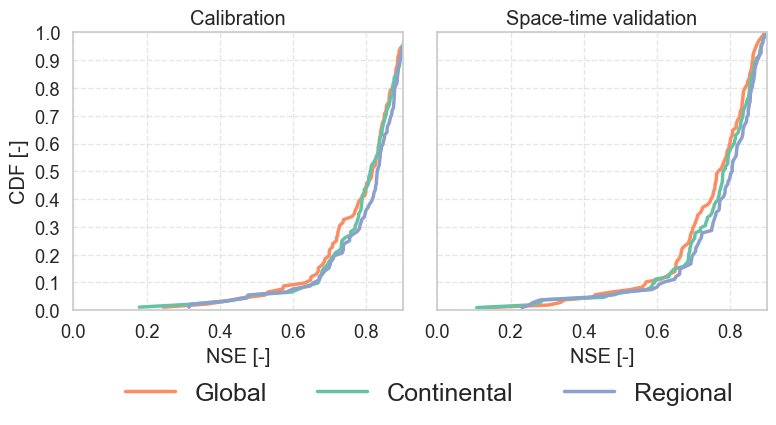

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

# Plotting function
def plot_cdf_mean(ax, data_input, title, label_letter):
    # Check if input is a dict or DataFrame
    if isinstance(data_input, dict):
        dfs = list(data_input.values())
        all_data = pd.concat(dfs, axis=0)
    elif isinstance(data_input, pd.DataFrame):
        all_data = data_input.copy()
    else:
        raise ValueError("data_input must be a dict of DataFrames or a single DataFrame.")
    
    data_combined = all_data.groupby(all_data.index).mean()

    for model_type in ['nse_g1comp', 'nse_c1comp', 'nse_r1comp']:
        if model_type not in data_combined.columns:
            continue
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        ax.plot(
            nse_values, cumulative,
            color=colors[model_type],
            linewidth=2.5,
            label=labels_pretty[model_type]
        )

    ax.set_title(title)
    ax.set_xlim(-0.0, 0.9)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("NSE [-]")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    # Subplot label (a, b, c)
    ax.text(0, 1.075, label_letter, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')


# Set styles
sns.set(style="whitegrid", font_scale=1.2)

# Color and label maps
colors = {
    'nse_g1comp': '#fc8d62',
    'nse_c1comp': '#66c2a5',
    'nse_r1comp': '#8da0cb',
}
labels_pretty = {
    'nse_g1comp': r"Global",
    'nse_c1comp': r"Continental",
    'nse_r1comp': r"Regional",
}

# --- FIGURE 1: CDF plots ---
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Calibration and space validation use dictionaries
plot_cdf_mean(axs[0], data_diff_calibration_complete_dict_plot, "Calibration", "")
axs[0].set_ylabel("CDF [-]")

#plot_cdf_mean(axs[1], data_diff_cal_complete_dict_plot, "Space validation", "b")

# Space-time validation uses the DataFrame directly
plot_cdf_mean(axs[1], data_diff_val_complete_dict_plot, "Space-time validation", "")

# Legend shared
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,
           #title="Model experiment",
           loc='lower center',
           bbox_to_anchor=(0.55, -0.1),
           ncol=4,
           fontsize=18,
           title_fontsize=14,
           frameon=False)

# Final layout
plt.tight_layout()
plt.savefig(
    "../results/figs/poster_cdfs.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


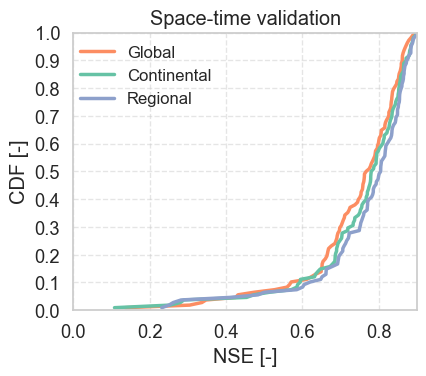

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

# Plotting function
def plot_cdf_mean(ax, data_input, title, label_letter):
    # Check if input is a dict or DataFrame
    if isinstance(data_input, dict):
        dfs = list(data_input.values())
        all_data = pd.concat(dfs, axis=0)
    elif isinstance(data_input, pd.DataFrame):
        all_data = data_input.copy()
    else:
        raise ValueError("data_input must be a dict of DataFrames or a single DataFrame.")
    
    data_combined = all_data.groupby(all_data.index).mean()

    for model_type in ['nse_g1comp', 'nse_c1comp', 'nse_r1comp']:
        if model_type not in data_combined.columns:
            continue
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        ax.plot(
            nse_values, cumulative,
            color=colors[model_type],
            linewidth=2.5,
            label=labels_pretty[model_type]
        )

    ax.set_title(title)
    ax.set_xlim(-0.0, 0.9)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("NSE [-]")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    # Subplot label (a, b, c)
    ax.text(0, 1.075, label_letter, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')


# Set styles
sns.set(style="whitegrid", font_scale=1.2)

# Color and label maps
colors = {
    'nse_g1comp': '#fc8d62',
    'nse_c1comp': '#66c2a5',
    'nse_r1comp': '#8da0cb',
}
labels_pretty = {
    'nse_g1comp': r"Global",
    'nse_c1comp': r"Continental",
    'nse_r1comp': r"Regional",
}

# --- FIGURE 1: CDF plots ---
fig, axs = plt.subplots(1, 1, figsize=(4.5, 4), sharey=True)

# Calibration and space validation use dictionaries
#plot_cdf_mean(axs, data_diff_calibration_complete_dict_plot, "Calibration", "")
axs.set_ylabel("CDF [-]")

#plot_cdf_mean(axs[1], data_diff_cal_complete_dict_plot, "Space validation", "b")

# Space-time validation uses the DataFrame directly
plot_cdf_mean(axs, data_diff_val_complete_dict_plot, "Space-time validation", "")

# Legend shared
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels,
           #title="Model experiment",
           loc='center',
           bbox_to_anchor=(0.35, 0.78),
           ncol=1,
           fontsize=12,
           title_fontsize=14,
           frameon=False)

# Final layout
plt.tight_layout()
plt.savefig(
    "../results/figs/poster_cdfs.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_40569/4209680022.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


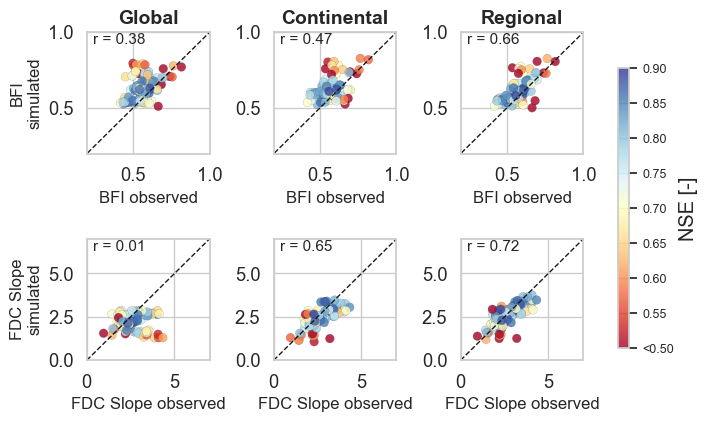

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define variables and pretty titles
metrics = ['bfi', 'slope']
metric_titles = ['BFI', 'FDC Slope']

# Define suffixes and scales
suffixes = ['g1comp', 'c1comp', 'r1comp']
scale_titles = [r"Global", "Continental", "Regional"]

# Colormap and normalization
cmap = plt.cm.RdYlBu
vmin, vmax = 0.5, 0.9
norm = Normalize(vmin=vmin, vmax=vmax)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(7, 4), sharex=False, sharey=False)
letters = list(string.ascii_lowercase)

# For shared colorbar, store one scatter artist
scatter_for_colorbar = None

# Loop through rows and columns
for row, (metric, row_title) in enumerate(zip(metrics, metric_titles)):
    for col, (suffix, scale_title) in enumerate(zip(suffixes, scale_titles)):
        ax = axs[row, col]
        var_obs = f"{metric}_obs"
        var_pred = f"{metric}_{suffix}"
        var_nse = f"nse_{suffix}"

        # Color values clipped to [0.5, 0.9]
        colors = data_diff_val_complete[var_nse].clip(lower=vmin, upper=vmax)

        # Scatterplot
        sc = ax.scatter(
            data_diff_val_complete[var_obs],
            data_diff_val_complete[var_pred],
            c=colors,
            cmap=cmap,
            norm=norm,
            s=40,
            edgecolor='k',
            linewidth=0.1,
            alpha=0.8
        )

        # Store one artist for colorbar
        if scatter_for_colorbar is None:
            scatter_for_colorbar = sc


        # Labels
        if col == 0:
            ax.set_ylabel(f"{row_title}\nsimulated", fontsize=12)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(f"{row_title} observed", fontsize=12)

        # Correlation
        R = data_diff_val_complete[[var_obs, var_pred]].corr(method="pearson").iloc[0, 1]
        ax.text(
            0.05, 0.9, f"r = {R:.2f}", transform=ax.transAxes,
            fontsize=11, bbox=dict(facecolor='none', alpha=0.6, edgecolor='none')
        )

        # Subplot label
        subplot_idx = row * 4 + col
        #ax.text(
        #    -0.00, 1.14, f"{letters[subplot_idx]}", transform=ax.transAxes,
        #    fontsize=13, fontweight='bold', va='top', ha='left'
        #)

        # Set axis limits per metric
        if metric == 'bfi':
            ax.set_xlim(0.2, 1)
            ax.set_ylim(0.2, 1)
        elif metric == 'slope':
            ax.set_xlim(0, 7)
            ax.set_ylim(0, 7)
        elif metric == 'hfd':
            ax.set_xlim(110, 175)
            ax.set_ylim(110, 175)

axs[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 2].plot([0, 1], [0, 1], 'k--', lw=1)
#axs[0, 3].plot([0, 1], [0, 1], 'k--', lw=1)

axs[1, 0].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 1].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 2].plot([0, 7], [0, 7], 'k--', lw=1)
#axs[1, 3].plot([0, 7], [0, 7], 'k--', lw=1)

#axs[2, 0].plot([100, 180], [100, 180], 'k--', lw=1)
#axs[2, 1].plot([100, 180], [100, 180], 'k--', lw=1)
#axs[2, 2].plot([100, 180], [100, 180], 'k--', lw=1)
#axs[2, 3].plot([100, 180], [100, 180], 'k--', lw=1)


# Add single vertical colorbar to the right
fig.subplots_adjust(right=0.88)  # Make room for colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter_for_colorbar, cax=cbar_ax)
cbar.set_label("NSE [-]")
cbar.ax.tick_params(labelsize=9)



# Custom ticks and labels
ticks = np.linspace(0.5, 0.9, num=9)  # Adjust number of ticks if needed
tick_labels = [f"<0.50"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.90"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

## Column titles (below x-axis)
#col_positions = [0.25, 0.5, 0.79]
#for x, title in zip(col_positions, scale_titles):
#    fig.text(x, -0.1, title, ha='center', va='bottom', fontsize=14, fontweight='bold')
axs[0, 0].set_title("Global", fontsize=14, fontweight='bold')
axs[0, 1].set_title("Continental", fontsize=14, fontweight='bold')
axs[0, 2].set_title("Regional", fontsize=14, fontweight='bold')


# Final layout
plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.85)

# Optional save
plt.savefig("../results/figs/poster_signatures_colorbar.png", dpi=300,  bbox_inches="tight")

plt.show()

In [84]:
gdf = gpd.read_file(r"/Users/nascimth/Documents/data/gis/world.shp")


In [92]:
moselle.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, label='Sub-catchments')


<Axes: xlabel='FDC Slope observed'>

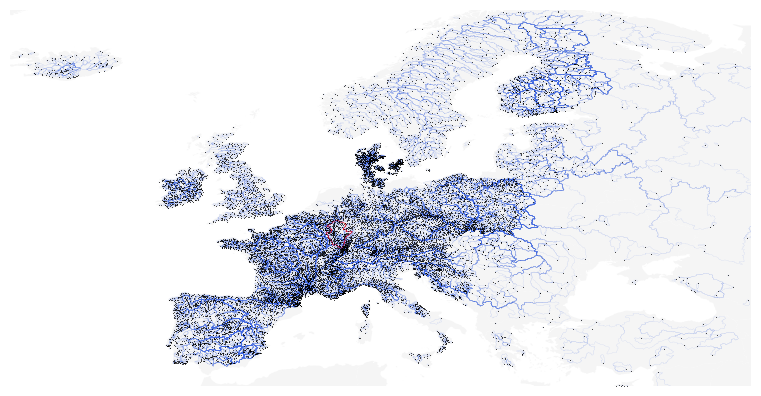

In [ ]:
# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 8          # Change the font size
mpl.rcParams['font.weight'] = 'normal'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

# Create a 2x1 subplot grid
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

# Set the background color to white
axs.set_facecolor('white')
# Plot the shapefile with white facecolor and black boundaries
gdf.plot(ax=axs, facecolor='whitesmoke', edgecolor='None', linewidth=0.1)
axs.set_xlim(-24, 45) 
axs.set_ylim(35, 70)  

catchment_boundaries.plot(ax=axs, facecolor='None', edgecolor='royalblue', linewidth=0.05,  alpha=0.70)

moselle.plot(ax=axs, facecolor='none', edgecolor='red', linewidth=0.25, label='Sub-catchments')
axs.set_xlim(-24, 45) 
axs.set_ylim(35, 70)  

# Plot the gauges
axs.scatter(network_estreams['lon_snap'], network_estreams['lat_snap'], color='black', edgecolor='black',linewidth=0.5,
            marker='o', s=0.05, label = "Streamflow gauges")  # Adjust color, marker, and size as needed

axs.set_aspect('equal')  # Adjust aspect ratio as needed
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_axis_off()  # Turn off both x-axis and y-axis

# Plot invisible scatter plot for legend
axs.plot([], [], color='royalblue', linewidth=0.8, label='Catchemnt boundaries')

#axs.legend(['Streamflow gauges', 'Catchment boundaries'], loc='lower left', frameon=False)


# Adjust layout and remove space between subplots
plt.tight_layout()

# Save or display the plot
#plt.show()
plt.savefig('../results/poster_figure_map.png', dpi=300)  # Replace 'figure.png' with your desired filename and forma

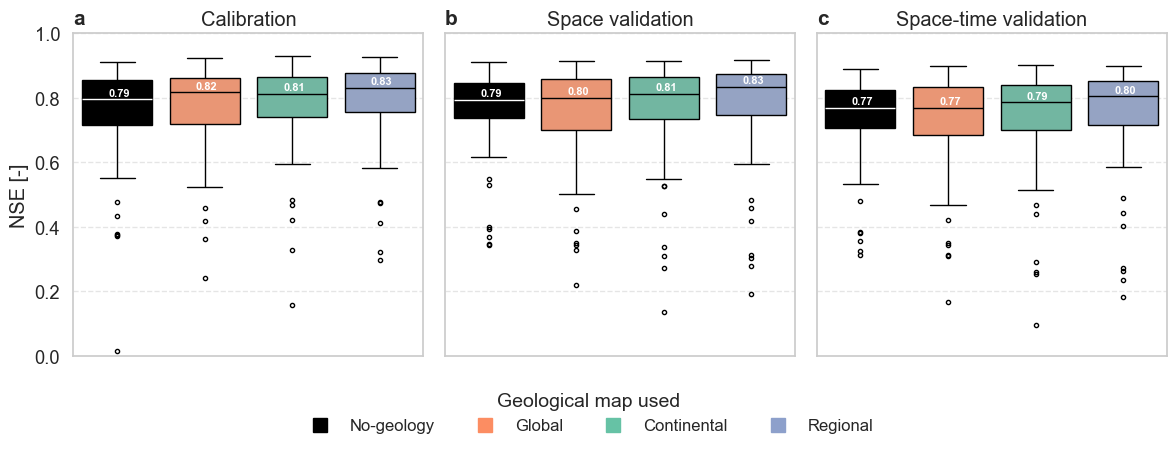

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Model labels and colors
column_label_map = {
    'nse_nogeo': 'No-Geology',
    'nse_g1comp': 'Global',
    'nse_c1comp': 'Continental',
    'nse_r1comp': 'Regional'
}
colors_box = {
    'No-Geology': 'black',
    'Global': '#fc8d62',
    'Continental': '#66c2a5',
    'Regional': '#8da0cb'
}

# Your input DataFrames for the three cases
dataframes = [
    data_diff_calibration_complete,
    data_diff_cal_complete,
    data_diff_val_complete
]
titles = ['Calibration', 'Space validation', 'Space-time validation']
subplot_labels = ['a', 'b', 'c']

# Create tidy DataFrames for seaborn
tidy_dataframes = []
for df, name in zip(dataframes, titles):
    df_tidy = pd.DataFrame({
        'NSE': pd.concat([df[col] for col in column_label_map]),
        'Model': sum([[column_label_map[col]] * len(df) for col in column_label_map], []),
        'Validation': name
    })
    tidy_dataframes.append(df_tidy)

df_all = pd.concat(tidy_dataframes, ignore_index=True)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, (ax, title, label) in enumerate(zip(axs, titles, subplot_labels)):
    df_sub = df_all[df_all["Validation"] == title]

    sns.boxplot(
        data=df_sub,
        x="Model",
        y="NSE",
        hue="Model",
        palette=colors_box,
        linewidth=1,
        fliersize=3,
        dodge=False,
        ax=ax
    )

    # Remove auto-generated legend
    if ax.get_legend():
        ax.get_legend().remove()

    # Annotate medians
    median_lines = ax.lines[4::6]
    for line in median_lines:
        y_data, x_data = line.get_xydata().mean(axis=0)
        ax.text(y_data - 0.1, x_data + 0.02, f"{x_data:.2f}", ha='left', va='center',
                fontweight='bold', fontsize=8, color='white')

        model_names = df_sub['Model'].unique()
        model_index = int(round(y_data))
        if model_index < len(model_names) and model_names[model_index] == 'No-Geology':
            line.set_color('white')

    ax.set_title(title)

    if i == 0:
        ax.set_ylabel("NSE [-]")
    else:
        ax.set_ylabel("")
        ax.tick_params(labelleft=False)  # Fully remove y-tick labels for right panels
    
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Subplot label (a, b, c)
    ax.text(-0.0, 1.075, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')

# Custom legend below
custom_handles = [
    mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label='No-geology'),
    mlines.Line2D([], [], color='#fc8d62', marker='s', linestyle='None', markersize=10, label='Global'),
    mlines.Line2D([], [], color='#66c2a5', marker='s', linestyle='None', markersize=10, label='Continental'),
    mlines.Line2D([], [], color='#8da0cb', marker='s', linestyle='None', markersize=10, label='Regional'),
]

fig.legend(
    handles=custom_handles,
    title="Geological map used",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize=12,
    title_fontsize=14,
    frameon=False
)

plt.tight_layout()
plt.savefig("../results/figs/three_cdfs.png", dpi=300, bbox_inches='tight')
plt.show()

# End